In [1]:
import os
import math

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn import metrics, mixture, cluster, datasets
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA, SparsePCA, KernelPCA, NMF
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import minmax_scale

from mlxtend.preprocessing import minmax_scaling

import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [2]:
font = {"family" : "sans serif",
        "size"   : 15}

matplotlib.rc("font", **font)

In [3]:
import math

In [4]:
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns[:-1]):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)

In [5]:
def plot_distribution_against_label(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use("seaborn-whitegrid")
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns[:-1]):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        sns.distplot(dataset.loc[dataset["won"] == 0][column], kde_kws={"label": "DEM"})
        sns.distplot(dataset.loc[dataset["won"] == 1][column], kde_kws={"label": "REP"})
        ax.legend()

In [6]:
def plot_boxplot_against_label(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns[:-1]):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        sns.boxplot(data=dataset, x="won", y=column)
        #ax.legend()

In [7]:
governors_path = "data/governors_county_candidate.csv"
president_path = "data/president_county_candidate.csv"
senate_path = "data/senate_county_candidate.csv"
census_path = "data/acs2017_county_data.csv"

In [8]:
df_president = pd.read_csv(president_path)
df_census = pd.read_csv(census_path)
df_census = df_census.rename(columns={"State": "state", "County": "county"})

In [9]:
df_president

state             county      candidate party  total_votes    won
0      Delaware        Kent County      Joe Biden   DEM        44552   True
1      Delaware        Kent County   Donald Trump   REP        41009  False
2      Delaware        Kent County   Jo Jorgensen   LIB         1044  False
3      Delaware        Kent County  Howie Hawkins   GRN          420  False
4      Delaware  New Castle County      Joe Biden   DEM       195034   True
...         ...                ...            ...   ...          ...    ...
32172   Arizona    Maricopa County      Write-ins   WRI         1331  False
32173   Arizona      Mohave County   Donald Trump   REP        78535   True
32174   Arizona      Mohave County      Joe Biden   DEM        24831  False
32175   Arizona      Mohave County   Jo Jorgensen   LIB         1302  False
32176   Arizona      Mohave County      Write-ins   WRI           37  False

[32177 rows x 6 columns]

In [10]:
df_president_percentage_votes = df_president.groupby(["state", "county", "party"])["total_votes"].aggregate(np.sum) / df_president.groupby(["state", "county"])["total_votes"].aggregate(np.sum)

In [11]:
df_president_percentage_votes = df_president_percentage_votes.to_frame()
df_president_percentage_votes = df_president_percentage_votes.reset_index(level=["state", "county", "party"])

In [12]:
df_president_percentage_votes = df_president_percentage_votes.rename(columns={"total_votes": "percentage_votes"})

In [13]:
df_president_percentage_votes

state          county party  percentage_votes
0      Alabama  Autauga County   DEM          0.270184
1      Alabama  Autauga County   LIB          0.012604
2      Alabama  Autauga County   REP          0.714368
3      Alabama  Autauga County   WRI          0.002845
4      Alabama  Baldwin County   DEM          0.224090
...        ...             ...   ...               ...
29975  Wyoming   Weston County   DEM          0.101637
29976  Wyoming   Weston County   IND          0.005647
29977  Wyoming   Weston County   LIB          0.012987
29978  Wyoming   Weston County   REP          0.877188
29979  Wyoming   Weston County   WRI          0.002541

[29980 rows x 4 columns]

In [14]:
df_president = df_president.merge(df_president_percentage_votes, on=["state", "county", "party"])

In [15]:
df_president

state             county      candidate party  total_votes    won  \
0      Delaware        Kent County      Joe Biden   DEM        44552   True   
1      Delaware        Kent County   Donald Trump   REP        41009  False   
2      Delaware        Kent County   Jo Jorgensen   LIB         1044  False   
3      Delaware        Kent County  Howie Hawkins   GRN          420  False   
4      Delaware  New Castle County      Joe Biden   DEM       195034   True   
...         ...                ...            ...   ...          ...    ...   
32172   Arizona    Maricopa County      Write-ins   WRI         1331  False   
32173   Arizona      Mohave County   Donald Trump   REP        78535   True   
32174   Arizona      Mohave County      Joe Biden   DEM        24831  False   
32175   Arizona      Mohave County   Jo Jorgensen   LIB         1302  False   
32176   Arizona      Mohave County      Write-ins   WRI           37  False   

       percentage_votes  
0              0.511945  
1              0.471232  
2              0.011997  
3              0.004826  
4              0.678065  
...                 ...  
32172          0.000643  
32173          0.750060  
32174          0.237152  
32175          0.012435  
32176          0.000353  

[32177 rows x 7 columns]

In [16]:
df_president_agg_REP  = df_president[(df_president.party=="REP")]
df_president_agg_DEM  = df_president[(df_president.party=="DEM")]

In [17]:
df_president_agg_REP

state                county     candidate party  \
1                  Delaware           Kent County  Donald Trump   REP   
5                  Delaware     New Castle County  Donald Trump   REP   
8                  Delaware         Sussex County  Donald Trump   REP   
13     District of Columbia  District of Columbia  Donald Trump   REP   
20     District of Columbia                Ward 2  Donald Trump   REP   
...                     ...                   ...           ...   ...   
32157               Arizona         Graham County  Donald Trump   REP   
32161               Arizona       Greenlee County  Donald Trump   REP   
32165               Arizona         La Paz County  Donald Trump   REP   
32170               Arizona       Maricopa County  Donald Trump   REP   
32173               Arizona         Mohave County  Donald Trump   REP   

       total_votes    won  percentage_votes  
1            41009  False          0.471232  
5            88364  False          0.307211  
8            71230   True          0.550668  
13            1725  False          0.041386  
20            2918  False          0.088744  
...            ...    ...               ...  
32157        10749   True          0.716791  
32161         2433   True          0.659707  
32165         5129   True          0.687534  
32170       995665  False          0.481120  
32173        78535   True          0.750060  

[4633 rows x 7 columns]

In [18]:
df_president_agg_REP = pd.DataFrame(df_president_agg_REP.groupby(["state", "county"])["percentage_votes", "won"].sum())
df_president_agg_DEM = pd.DataFrame(df_president_agg_DEM.groupby(["state", "county"])["percentage_votes"].sum())

In [19]:
df_president_agg_REP = df_president_agg_REP.rename(columns={"percentage_votes": "votes REP president perc"})
df_president_agg_DEM = df_president_agg_DEM.rename(columns={"percentage_votes": "votes DEM president perc"})

In [20]:
df_president_agg = pd.merge(df_president_agg_DEM, df_president_agg_REP, on=["state", "county"], how="left")
df_president_agg

votes DEM president perc  votes REP president perc  \
state   county                                                                  
Alabama Autauga County                     0.270184                  0.714368   
        Baldwin County                     0.224090                  0.761714   
        Barbour County                     0.457882                  0.534512   
        Bibb County                        0.206983                  0.784263   
        Blount County                      0.095694                  0.895716   
...                                             ...                       ...   
Wyoming Sweetwater County                  0.230260                  0.736554   
        Teton County                       0.670982                  0.295769   
        Uinta County                       0.169219                  0.797277   
        Washakie County                    0.162263                  0.808824   
        Weston County                      0.101637                  0.877188   

                           won  
state   county                  
Alabama Autauga County       1  
        Baldwin County       1  
        Barbour County       1  
        Bibb County          1  
        Blount County        1  
...                        ...  
Wyoming Sweetwater County    1  
        Teton County         0  
        Uinta County         1  
        Washakie County      1  
        Weston County        1  

[4633 rows x 3 columns]

In [21]:
df_president_agg.isnull().any()

votes DEM president perc    False
votes REP president perc    False
won                         False
dtype: bool

In [22]:
df_census

CountyId        state               county  TotalPop    Men   Women  \
0         1001      Alabama       Autauga County     55036  26899   28137   
1         1003      Alabama       Baldwin County    203360  99527  103833   
2         1005      Alabama       Barbour County     26201  13976   12225   
3         1007      Alabama          Bibb County     22580  12251   10329   
4         1009      Alabama        Blount County     57667  28490   29177   
...        ...          ...                  ...       ...    ...     ...   
3215     72145  Puerto Rico  Vega Baja Municipio     54754  26269   28485   
3216     72147  Puerto Rico    Vieques Municipio      8931   4351    4580   
3217     72149  Puerto Rico   Villalba Municipio     23659  11510   12149   
3218     72151  Puerto Rico    Yabucoa Municipio     35025  16984   18041   
3219     72153  Puerto Rico      Yauco Municipio     37585  18052   19533   

      Hispanic  White  Black  Native  ...  Walk  OtherTransp  WorkAtHome  \
0          2.7   75.4   18.9     0.3  ...   0.6          1.3         2.5   
1          4.4   83.1    9.5     0.8  ...   0.8          1.1         5.6   
2          4.2   45.7   47.8     0.2  ...   2.2          1.7         1.3   
3          2.4   74.6   22.0     0.4  ...   0.3          1.7         1.5   
4          9.0   87.4    1.5     0.3  ...   0.4          0.4         2.1   
...        ...    ...    ...     ...  ...   ...          ...         ...   
3215      96.7    3.1    0.1     0.0  ...   1.4          0.6         0.9   
3216      95.7    4.0    0.0     0.0  ...   5.0          0.0         1.7   
3217      99.7    0.2    0.1     0.0  ...   2.1          0.0         2.8   
3218      99.9    0.1    0.0     0.0  ...   1.4          1.8         0.1   
3219      99.8    0.2    0.0     0.0  ...   1.7          0.1         5.0   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0            25.8     24112         74.1        20.2           5.6   
1            27.0     89527         80.7        12.9           6.3   
2            23.4      8878         74.1        19.1           6.5   
3            30.0      8171         76.0        17.4           6.3   
4            35.0     21380         83.9        11.9           4.0   
...           ...       ...          ...         ...           ...   
3215         31.6     14234         76.2        19.3           4.3   
3216         14.9      2927         40.7        40.9          18.4   
3217         28.4      6873         59.2        30.2          10.4   
3218         30.5      7878         62.7        30.9           6.3   
3219         24.4      8995         66.4        28.7           5.0   

      FamilyWork  Unemployment  
0            0.1           5.2  
1            0.1           5.5  
2            0.3          12.4  
3            0.3           8.2  
4            0.1           4.9  
...          ...           ...  
3215         0.2          16.8  
3216         0.0          12.8  
3217         0.2          24.8  
3218         0.0          25.4  
3219         0.0          24.0  

[3220 rows x 37 columns]

In [23]:
vars_to_merge = [x for x in df_census.columns if x not in ["CountyId", "state", "county"]]

df_census_agg = pd.DataFrame(df_census.groupby(["state", "county"])[vars_to_merge].sum())
df_census_agg

TotalPop    Men   Women  Hispanic  White  Black  \
state   county                                                               
Alabama Autauga County        55036  26899   28137       2.7   75.4   18.9   
        Baldwin County       203360  99527  103833       4.4   83.1    9.5   
        Barbour County        26201  13976   12225       4.2   45.7   47.8   
        Bibb County           22580  12251   10329       2.4   74.6   22.0   
        Blount County         57667  28490   29177       9.0   87.4    1.5   
...                             ...    ...     ...       ...    ...    ...   
Wyoming Sweetwater County     44527  22981   21546      16.0   79.6    0.8   
        Teton County          22923  12169   10754      15.0   81.5    0.5   
        Uinta County          20758  10593   10165       9.1   87.7    0.1   
        Washakie County        8253   4118    4135      14.2   82.2    0.3   
        Weston County          7117   3756    3361       1.4   91.6    0.5   

                           Native  Asian  Pacific  VotingAgeCitizen  ...  \
state   county                                                       ...   
Alabama Autauga County        0.3    0.9      0.0             41016  ...   
        Baldwin County        0.8    0.7      0.0            155376  ...   
        Barbour County        0.2    0.6      0.0             20269  ...   
        Bibb County           0.4    0.0      0.0             17662  ...   
        Blount County         0.3    0.1      0.0             42513  ...   
...                           ...    ...      ...               ...  ...   
Wyoming Sweetwater County     0.6    0.6      0.5             31025  ...   
        Teton County          0.3    2.2      0.0             16692  ...   
        Uinta County          0.9    0.1      0.0             14235  ...   
        Washakie County       0.4    0.1      0.0              6125  ...   
        Weston County         0.1    4.3      0.0              5510  ...   

                           Walk  OtherTransp  WorkAtHome  MeanCommute  \
state   county                                                          
Alabama Autauga County      0.6          1.3         2.5         25.8   
        Baldwin County      0.8          1.1         5.6         27.0   
        Barbour County      2.2          1.7         1.3         23.4   
        Bibb County         0.3          1.7         1.5         30.0   
        Blount County       0.4          0.4         2.1         35.0   
...                         ...          ...         ...          ...   
Wyoming Sweetwater County   2.8          1.3         1.5         20.5   
        Teton County       11.7          3.8         5.7         14.3   
        Uinta County        1.1          1.3         2.0         19.9   
        Washakie County     6.9          1.3         4.4         14.3   
        Weston County       3.0          1.6         6.9         25.7   

                           Employed  PrivateWork  PublicWork  SelfEmployed  \
state   county                                                               
Alabama Autauga County        24112         74.1        20.2           5.6   
        Baldwin County        89527         80.7        12.9           6.3   
        Barbour County         8878         74.1        19.1           6.5   
        Bibb County            8171         76.0        17.4           6.3   
        Blount County         21380         83.9        11.9           4.0   
...                             ...          ...         ...           ...   
Wyoming Sweetwater County     22739         78.4        17.8           3.8   
        Teton County          14492         82.1        11.4           6.5   
        Uinta County           9528         71.5        21.5           6.6   
        Washakie County        3833         69.8        22.0           8.1   
        Weston County          3407         68.2        21.9           8.8   

                           FamilyWork  Unemployment  
stat

In [24]:
df = pd.merge(df_president_agg, df_census_agg, on=["state", "county"], how="left")

missing_percentage = (df.isnull().sum()).sum() / np.product(df.shape) * 100
print("The number of missing entries before cleaning: " + str(round(missing_percentage, 5)) + " %")

The number of missing entries before cleaning: 31.51656 %


In [25]:
df_null = df[df.isnull().any(axis=1)]
null_county = np.array(df_null.index.get_level_values("county"))
null_county

array(['ED 1', 'ED 10', 'ED 11', ..., 'Woodford', 'Woodstock',
       'Worcester'], dtype=object)

In [26]:
df

votes DEM president perc  votes REP president perc  \
state   county                                                                  
Alabama Autauga County                     0.270184                  0.714368   
        Baldwin County                     0.224090                  0.761714   
        Barbour County                     0.457882                  0.534512   
        Bibb County                        0.206983                  0.784263   
        Blount County                      0.095694                  0.895716   
...                                             ...                       ...   
Wyoming Sweetwater County                  0.230260                  0.736554   
        Teton County                       0.670982                  0.295769   
        Uinta County                       0.169219                  0.797277   
        Washakie County                    0.162263                  0.808824   
        Weston County                      0.101637                  0.877188   

                           won  TotalPop      Men     Women  Hispanic  White  \
state   county                                                                 
Alabama Autauga County       1   55036.0  26899.0   28137.0       2.7   75.4   
        Baldwin County       1  203360.0  99527.0  103833.0       4.4   83.1   
        Barbour County       1   26201.0  13976.0   12225.0       4.2   45.7   
        Bibb County          1   22580.0  12251.0   10329.0       2.4   74.6   
        Blount County        1   57667.0  28490.0   29177.0       9.0   87.4   
...                        ...       ...      ...       ...       ...    ...   
Wyoming Sweetwater County    1   44527.0  22981.0   21546.0      16.0   79.6   
        Teton County         0   22923.0  12169.0   10754.0      15.0   81.5   
        Uinta County         1   20758.0  10593.0   10165.0       9.1   87.7   
        Washakie County      1    8253.0   4118.0    4135.0      14.2   82.2   
        Weston County        1    7117.0   3756.0    3361.0       1.4   91.6   

                           Black  Native  ...  Walk  OtherTransp  WorkAtHome  \
state   county                            ...                                  
Alabama Autauga County      18.9     0.3  ...   0.6          1.3         2.5   
        Baldwin County       9.5     0.8  ...   0.8          1.1         5.6   
        Barbour County      47.8     0.2  ...   2.2          1.7         1.3   
        Bibb County         22.0     0.4  ...   0.3          1.7         1.5   
        Blount County        1.5     0.3  ...   0.4          0.4         2.1   
...                          ...     ...  ...   ...          ...         ...   
Wyoming Sweetwater County    0.8     0.6  ...   2.8          1.3         1.5   
        Teton County         0.5     0.3  ...  11.7          3.8         5.7   
        Uinta County         0.1     0.9  ...   1.1          1.3         2.0   
        Washakie County      0.3     0.4  ...   6.9          1.3         4.4   
        Weston County        0.5     0.1  ...   3.0          1.6         6.9   

                           MeanCommute  Employed  PrivateWork  PublicWork  \
state   county                                                              
Alabama Autauga County            25.8   24112.0         74.1        20.2   
        Baldwin County            27.0   89527.0         80.7        12.9   
        Barbour County            23.4    8878.0         74.1        19.1   
        Bibb County               30.0    8171.0         76.0        17.4   
        Blount County             35.0   21380.0         83.9        11.9   
...                                ...       ...          ...         ...   
Wyoming Sweetwater County         20.5   22739.0         78.4        17.8   
        Teton County              14.3   14492.0         82.1        11.4   
        Uinta County              19.9    9528.0         71.5        21.5   
        Washakie County           14.3    38

In [27]:
df.describe()

votes DEM president perc  votes REP president perc          won  \
count               4633.000000               4633.000000  4633.000000   
mean                   0.395545                  0.583575     0.694798   
std                    0.180893                  0.184270     0.460543   
min                    0.000000                  0.000000     0.000000   
25%                    0.246482                  0.452795     0.000000   
50%                    0.377551                  0.600056     1.000000   
75%                    0.523762                  0.733695     1.000000   
max                    1.000000                  1.000000     1.000000   

           TotalPop           Men         Women     Hispanic        White  \
count  3.044000e+03  3.044000e+03  3.044000e+03  3044.000000  3044.000000   
mean   1.003040e+05  4.939193e+04  5.091205e+04     9.236465    76.822208   
std    3.298855e+05  1.620033e+05  1.679204e+05    13.839033    19.932172   
min    7.400000e+01  3.900000e+01  3.500000e+01     0.000000     0.600000   
25%    1.095175e+04  5.507500e+03  5.464000e+03     2.100000    65.100000   
50%    2.545150e+04  1.265650e+04  1.272500e+04     4.000000    84.200000   
75%    6.579275e+04  3.254675e+04  3.303200e+04     9.425000    92.900000   
max    1.010572e+07  4.979641e+06  5.126081e+06    99.200000   100.000000   

             Black       Native  ...         Walk  OtherTransp   WorkAtHome  \
count  3044.000000  3044.000000  ...  3044.000000  3044.000000  3044.000000   
mean      9.111465     1.560545  ...     2.999244     1.524474     4.773489   
std      14.613863     6.483594  ...     2.884691     1.148155     3.099042   
min       0.000000     0.000000  ...     0.000000     0.000000     0.000000   
25%       0.600000     0.100000  ...     1.300000     0.800000     2.900000   
50%       2.200000     0.300000  ...     2.200000     1.300000     4.100000   
75%      10.500000     0.600000  ...     3.700000     1.900000     5.800000   
max      86.900000    90.300000  ...    42.400000    13.800000    33.000000   

       MeanCommute      Employed  PrivateWork   PublicWork  SelfEmployed  \
count  3044.000000  3.044000e+03  3044.000000  3044.000000   3044.000000   
mean     23.447109  4.684633e+04    75.186038    16.783837      7.746583   
std       5.528952  1.580536e+05     7.377630     5.993947      3.877439   
min       7.700000  3.900000e+01    31.100000     4.400000      0.000000   
25%      19.600000  4.529500e+03    71.700000    12.700000      5.200000   
50%      23.100000  1.053050e+04    76.300000    15.700000      6.700000   
75%      26.900000  2.859600e+04    80.300000    19.500000      9.100000   
max      45.100000  4.805817e+06    88.800000    64.800000     38.000000   

        FamilyWork  Unemployment  
count  3044.000000   3044.000000  
mean      0.284790      6.353318  
std       0.455191      3.023200  
min       0.000000      0.000000  
25%       0.100000      4.400000  
50%       0.200000      6.100000  
75%       0.300000      7.800000  
max       8.000000     28.700000  

[8 rows x 37 columns]

In [28]:
votes_perc = df.iloc[:,:2].columns
votes = df.iloc[:,:3].columns
factors = [x for x in df.columns if x not in votes]
df = df.fillna(0)

missing_percentage = (df.isnull().sum()).sum() / np.product(df.shape) * 100
print("The number of missing entries before cleaning: " + str(round(missing_percentage,5)) + " %")

The number of missing entries before cleaning: 0.0 %


In [29]:
print("Number of rows: "+ format(df.shape[0]) +", number of features: "+ format(df.shape[1]))

Number of rows: 4633, number of features: 37


In [30]:
C = (df.dtypes == "object")
categorical_variables = list(C[C].index)

Integer = (df.dtypes == "int64") 
Float   = (df.dtypes == "float64") 
numeric_variables = list(Integer[Integer].index) + list(Float[Float].index)
print("Number of numeric variables: " + format(len(numeric_variables)) + ", number of categorical features: " + format(len(categorical_variables)))

Number of numeric variables: 37, number of categorical features: 0


In [31]:
df_final = minmax_scaling(df, columns=df.columns[3:])
df_final

TotalPop       Men     Women  Hispanic  White  \
state   county                                                             
Alabama Autauga County     0.005446  0.005402  0.005489  0.027218  0.754   
        Baldwin County     0.020123  0.019987  0.020256  0.044355  0.831   
        Barbour County     0.002593  0.002807  0.002385  0.042339  0.457   
        Bibb County        0.002234  0.002460  0.002015  0.024194  0.746   
        Blount County      0.005706  0.005721  0.005692  0.090726  0.874   
...                             ...       ...       ...       ...    ...   
Wyoming Sweetwater County  0.004406  0.004615  0.004203  0.161290  0.796   
        Teton County       0.002268  0.002444  0.002098  0.151210  0.815   
        Uinta County       0.002054  0.002127  0.001983  0.091734  0.877   
        Washakie County    0.000817  0.000827  0.000807  0.143145  0.822   
        Weston County      0.000704  0.000754  0.000656  0.014113  0.916   

                              Black    Native     Asian  Pacific  \
state   county                                                     
Alabama Autauga County     0.217491  0.003322  0.021531  0.00000   
        Baldwin County     0.109321  0.008859  0.016746  0.00000   
        Barbour County     0.550058  0.002215  0.014354  0.00000   
        Bibb County        0.253165  0.004430  0.000000  0.00000   
        Blount County      0.017261  0.003322  0.002392  0.00000   
...                             ...       ...       ...      ...   
Wyoming Sweetwater County  0.009206  0.006645  0.014354  0.04386   
        Teton County       0.005754  0.003322  0.052632  0.00000   
        Uinta County       0.001151  0.009967  0.002392  0.00000   
        Washakie County    0.003452  0.004430  0.002392  0.00000   
        Weston County      0.005754  0.001107  0.102871  0.00000   

                           VotingAgeCitizen  ...      Walk  OtherTransp  \
state   county                               ...                          
Alabama Autauga County             0.006596  ...  0.014151     0.094203   
        Baldwin County             0.024987  ...  0.018868     0.079710   
        Barbour County             0.003260  ...  0.051887     0.123188   
        Bibb County                0.002840  ...  0.007075     0.123188   
        Blount County              0.006837  ...  0.009434     0.028986   
...                                     ...  ...       ...          ...   
Wyoming Sweetwater County          0.004989  ...  0.066038     0.094203   
        Teton County               0.002684  ...  0.275943     0.275362   
        Uinta County               0.002289  ...  0.025943     0.094203   
        Washakie County            0.000985  ...  0.162736     0.094203   
        Weston County              0.000886  ...  0.070755     0.115942   

                           WorkAtHome  MeanCommute  Employed  PrivateWork  \
state   county                                                              
Alabama Autauga County       0.075758     0.572062  0.005017     0.834459   
        Baldwin County       0.169697     0.598670  0.018629     0.908784   
        Barbour County       0.039394     0.518847  0.001847     0.834459   
        Bibb County          0.045455     0.665188  0.001700     0.855856   
        Blount County        0.063636     0.776053  0.004449     0.944820   
...                               ...          ...       ...          ...   
Wyoming Sweetwater County    0.045455     0.454545  0.004732     0.882883   
        Teton County         0.172727     0.317073  0.003016     0.924550   
        Uinta County         0.060606     0.441242  0.001983     0.805180   
        Washakie County      0.133333     0.317073  0.000798     0.786036   
        Weston County        0.209091     0.569845  0.000709     0.768018   

                           PublicWork  SelfEmployed  FamilyWork  Unemployment  
state   county                                                                 
Alabama Autauga

In [32]:
df_final = pd.concat([df.iloc[:, :3], df_final], axis=1)

In [33]:
df_final

votes DEM president perc  votes REP president perc  \
state   county                                                                  
Alabama Autauga County                     0.270184                  0.714368   
        Baldwin County                     0.224090                  0.761714   
        Barbour County                     0.457882                  0.534512   
        Bibb County                        0.206983                  0.784263   
        Blount County                      0.095694                  0.895716   
...                                             ...                       ...   
Wyoming Sweetwater County                  0.230260                  0.736554   
        Teton County                       0.670982                  0.295769   
        Uinta County                       0.169219                  0.797277   
        Washakie County                    0.162263                  0.808824   
        Weston County                      0.101637                  0.877188   

                           won  TotalPop       Men     Women  Hispanic  White  \
state   county                                                                  
Alabama Autauga County       1  0.005446  0.005402  0.005489  0.027218  0.754   
        Baldwin County       1  0.020123  0.019987  0.020256  0.044355  0.831   
        Barbour County       1  0.002593  0.002807  0.002385  0.042339  0.457   
        Bibb County          1  0.002234  0.002460  0.002015  0.024194  0.746   
        Blount County        1  0.005706  0.005721  0.005692  0.090726  0.874   
...                        ...       ...       ...       ...       ...    ...   
Wyoming Sweetwater County    1  0.004406  0.004615  0.004203  0.161290  0.796   
        Teton County         0  0.002268  0.002444  0.002098  0.151210  0.815   
        Uinta County         1  0.002054  0.002127  0.001983  0.091734  0.877   
        Washakie County      1  0.000817  0.000827  0.000807  0.143145  0.822   
        Weston County        1  0.000704  0.000754  0.000656  0.014113  0.916   

                              Black    Native  ...      Walk  OtherTransp  \
state   county                                 ...                          
Alabama Autauga County     0.217491  0.003322  ...  0.014151     0.094203   
        Baldwin County     0.109321  0.008859  ...  0.018868     0.079710   
        Barbour County     0.550058  0.002215  ...  0.051887     0.123188   
        Bibb County        0.253165  0.004430  ...  0.007075     0.123188   
        Blount County      0.017261  0.003322  ...  0.009434     0.028986   
...                             ...       ...  ...       ...          ...   
Wyoming Sweetwater County  0.009206  0.006645  ...  0.066038     0.094203   
        Teton County       0.005754  0.003322  ...  0.275943     0.275362   
        Uinta County       0.001151  0.009967  ...  0.025943     0.094203   
        Washakie County    0.003452  0.004430  ...  0.162736     0.094203   
        Weston County      0.005754  0.001107  ...  0.070755     0.115942   

                           WorkAtHome  MeanCommute  Employed  PrivateWork  \
state   county                                                              
Alabama Autauga County       0.075758     0.572062  0.005017     0.834459   
        Baldwin County       0.169697     0.598670  0.018629     0.908784   
        Barbour County       0.039394     0.518847  0.001847     0.834459   
        Bibb County          0.045455     0.665188  0.001700     0.855856   
        Blount County        0.063636     0.776053  0.004449     0.944820   
...                               ...          ...       ...          ...   
Wyoming Sweetwater County    0.045455     0.454545  0.004732     0.882883   
        Teton County         0.172727     0.317073  0.003016     0.924550   
        Uinta County         0.060606     0.441242  0.001983     0.805180   
        Washakie County      0.133333     0.317073  0.000798     0.786

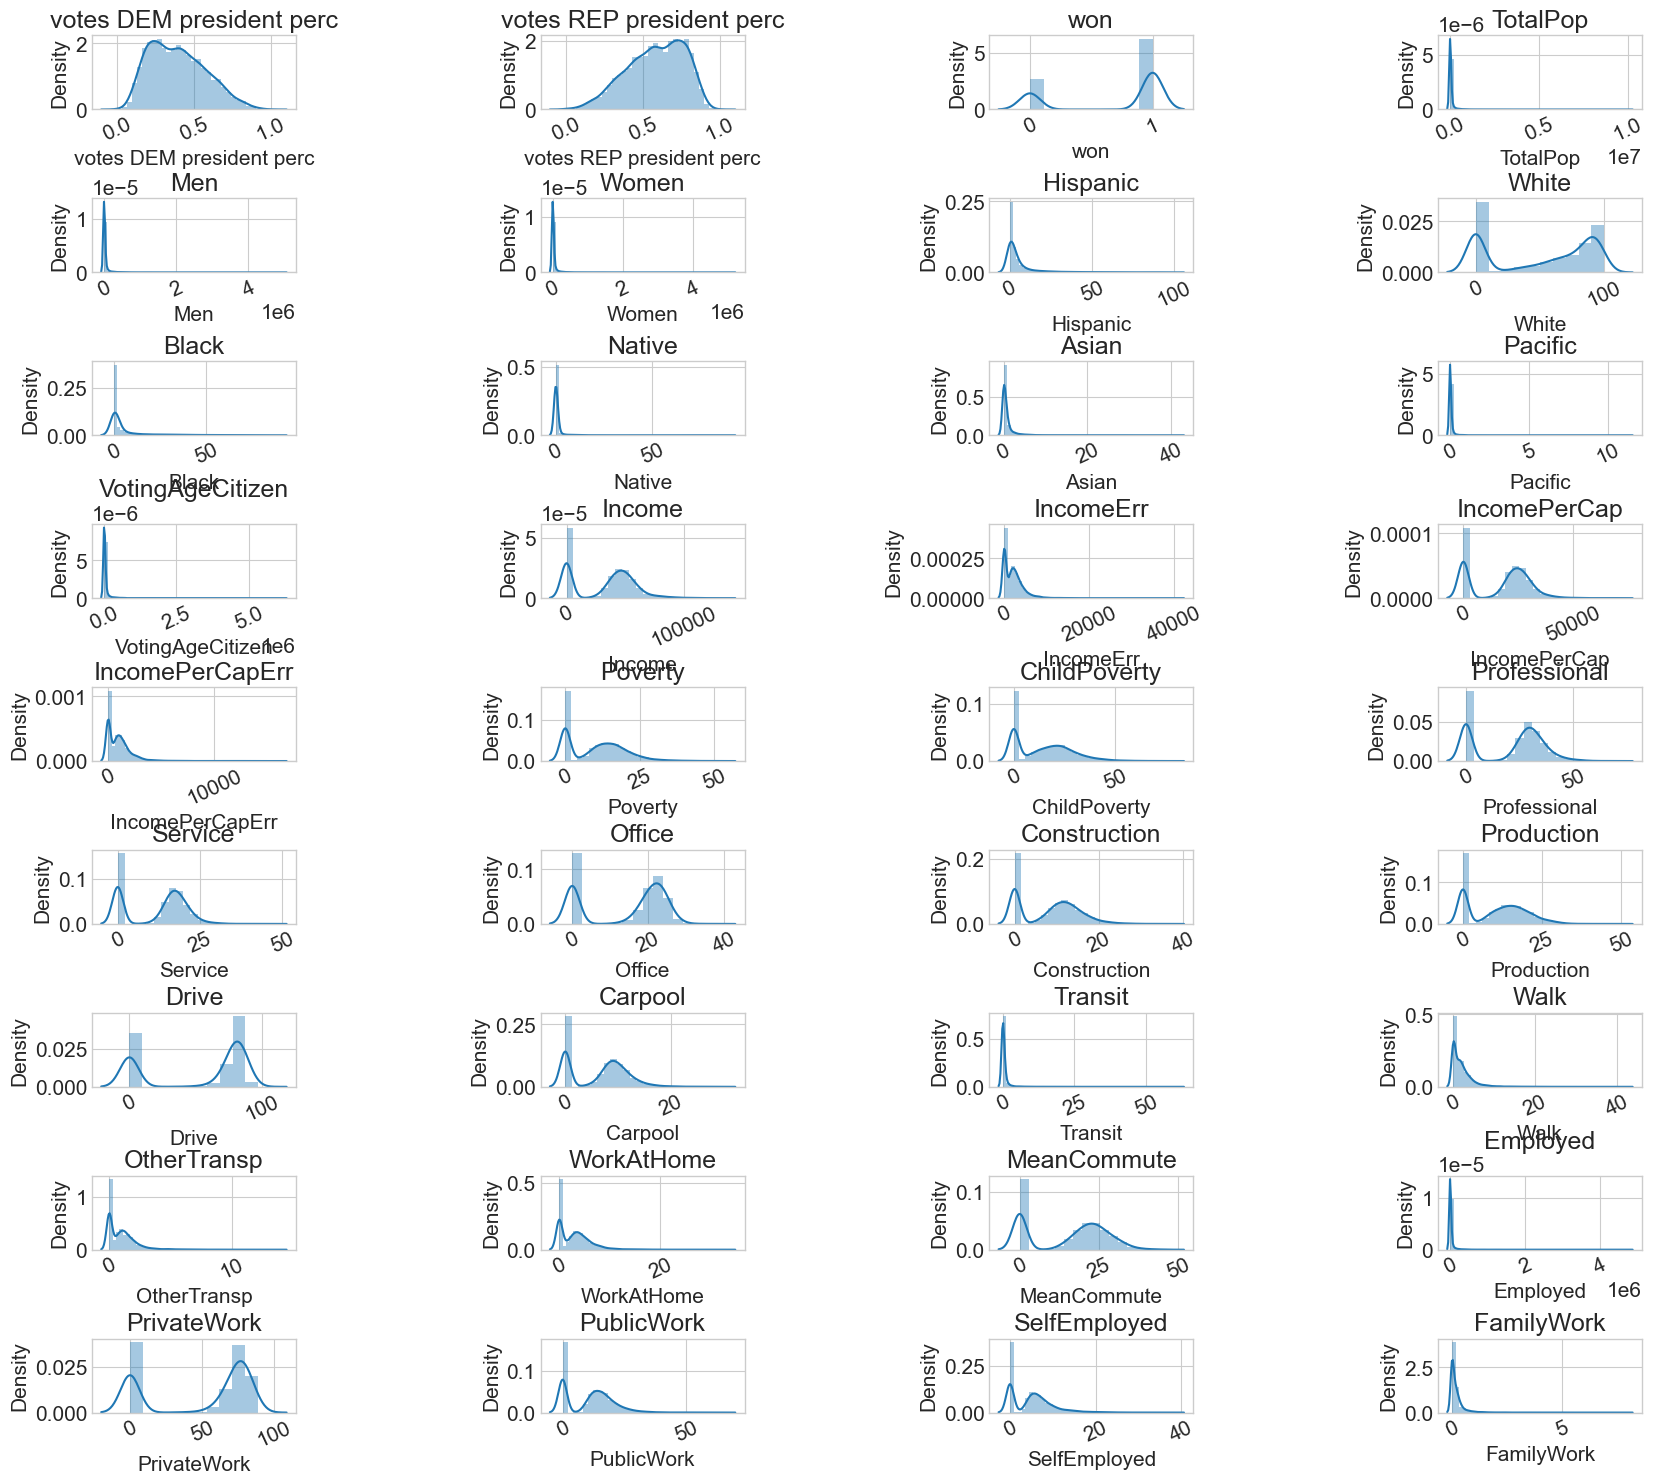

In [34]:
plot_distribution(df, cols=4, width=20, height=20, hspace=1.2, wspace=1.2)

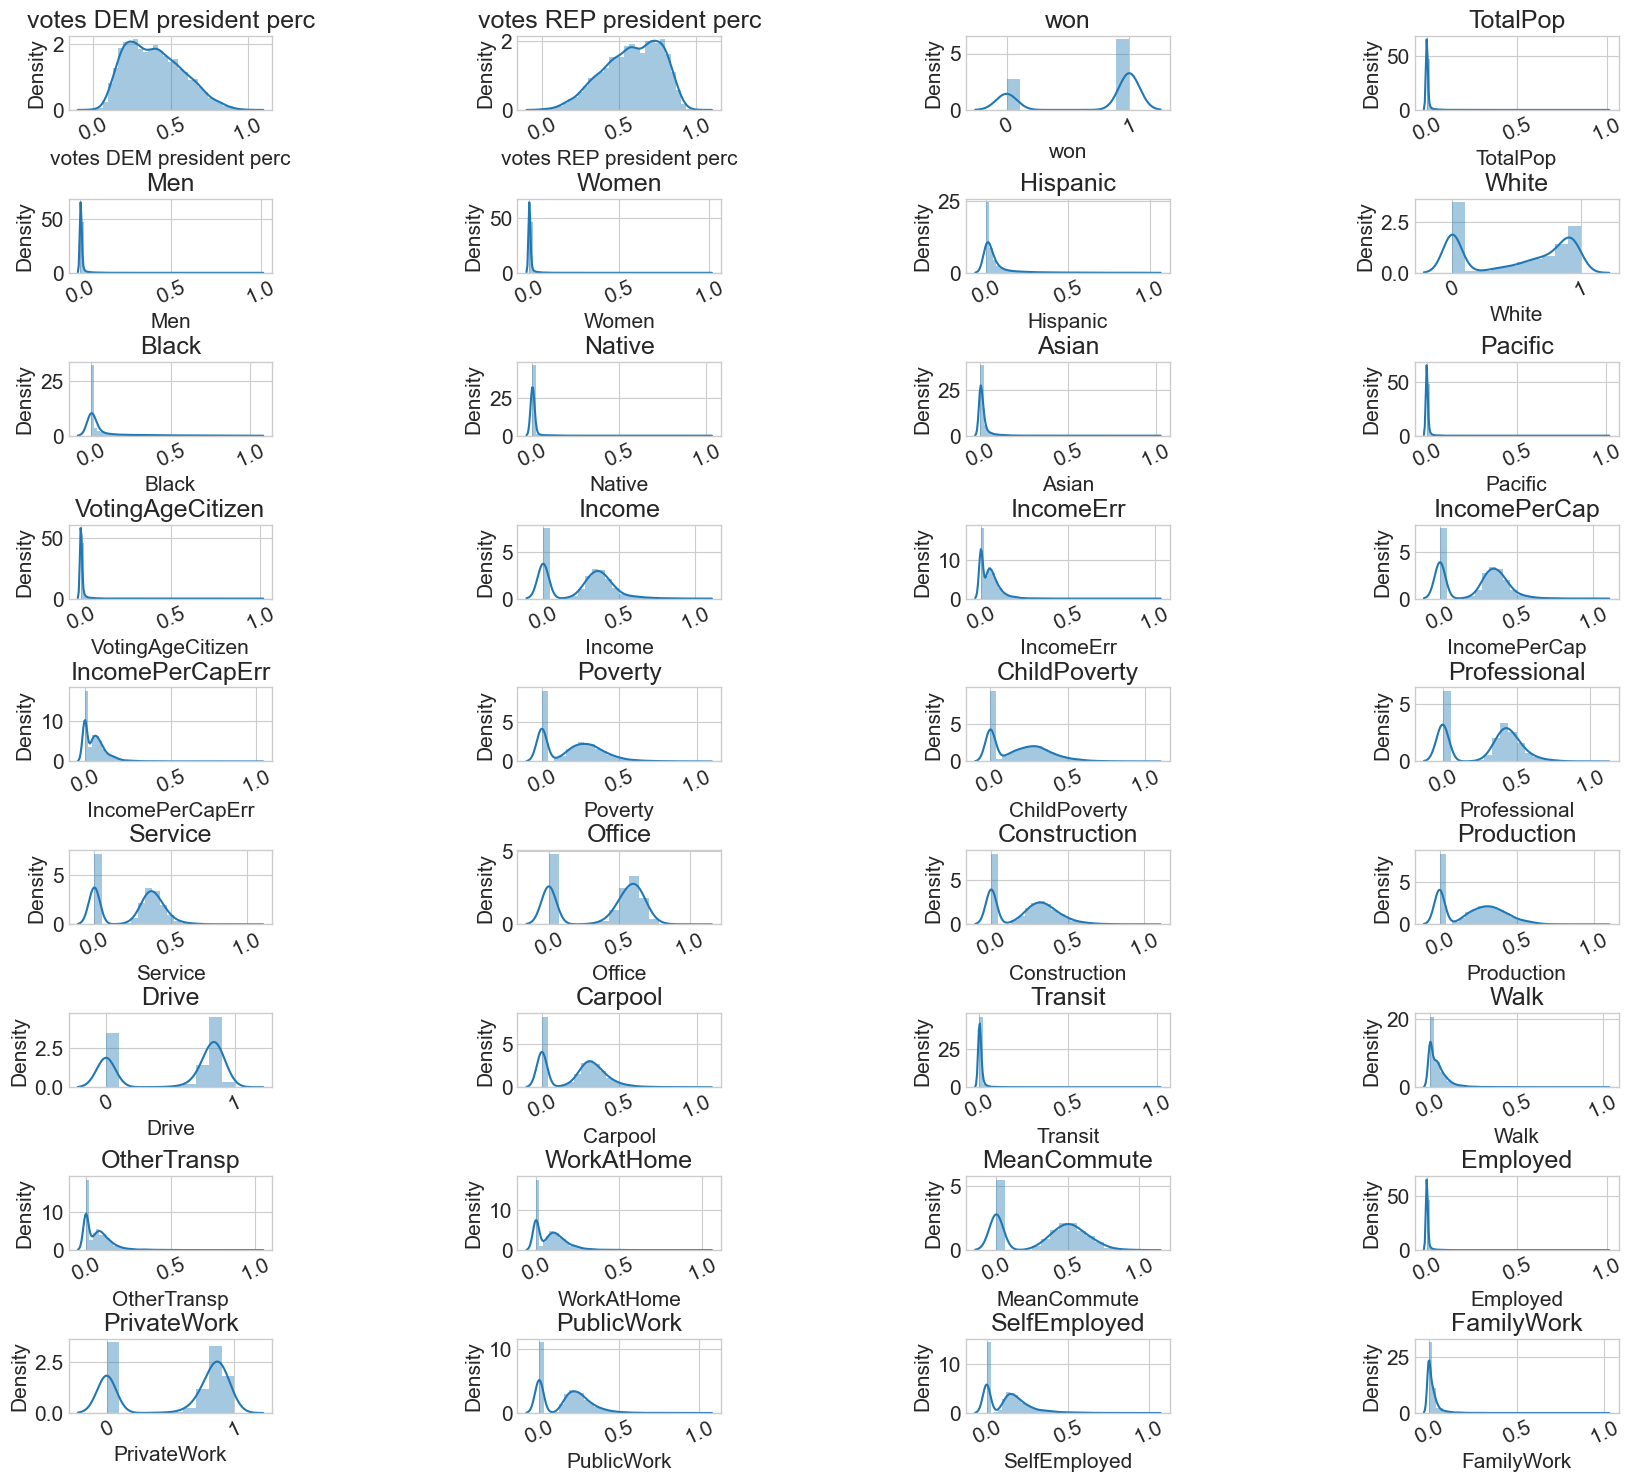

In [35]:
plot_distribution(df_final, cols=4, width=20, height=20, hspace=1.2, wspace=1.2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


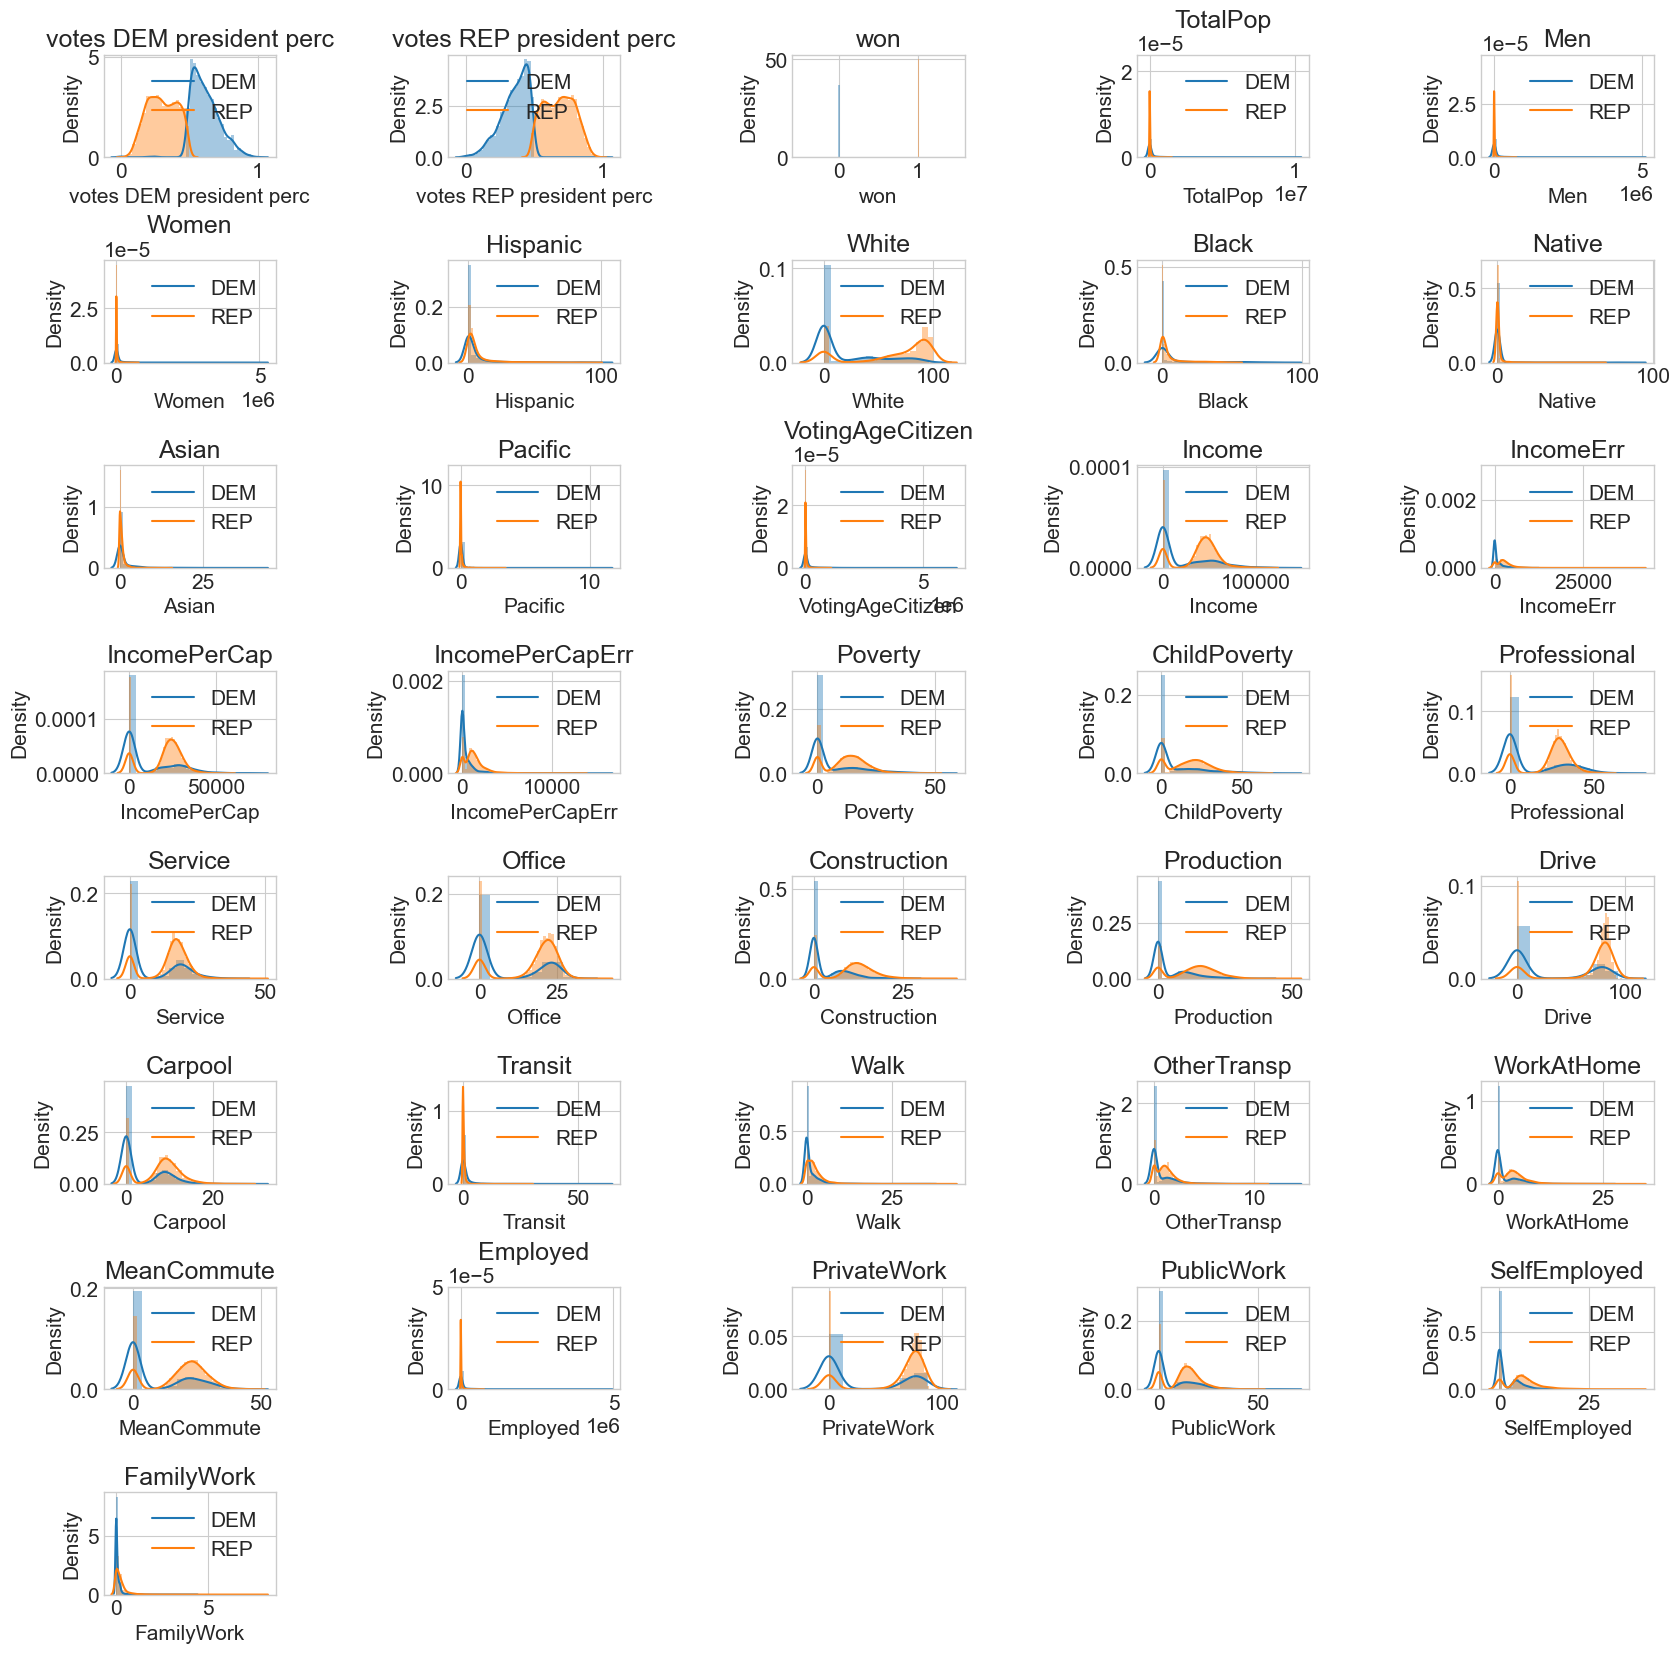

In [36]:
plot_distribution_against_label(df, cols=5, width=20, height=20, hspace=1.0, wspace=1.0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


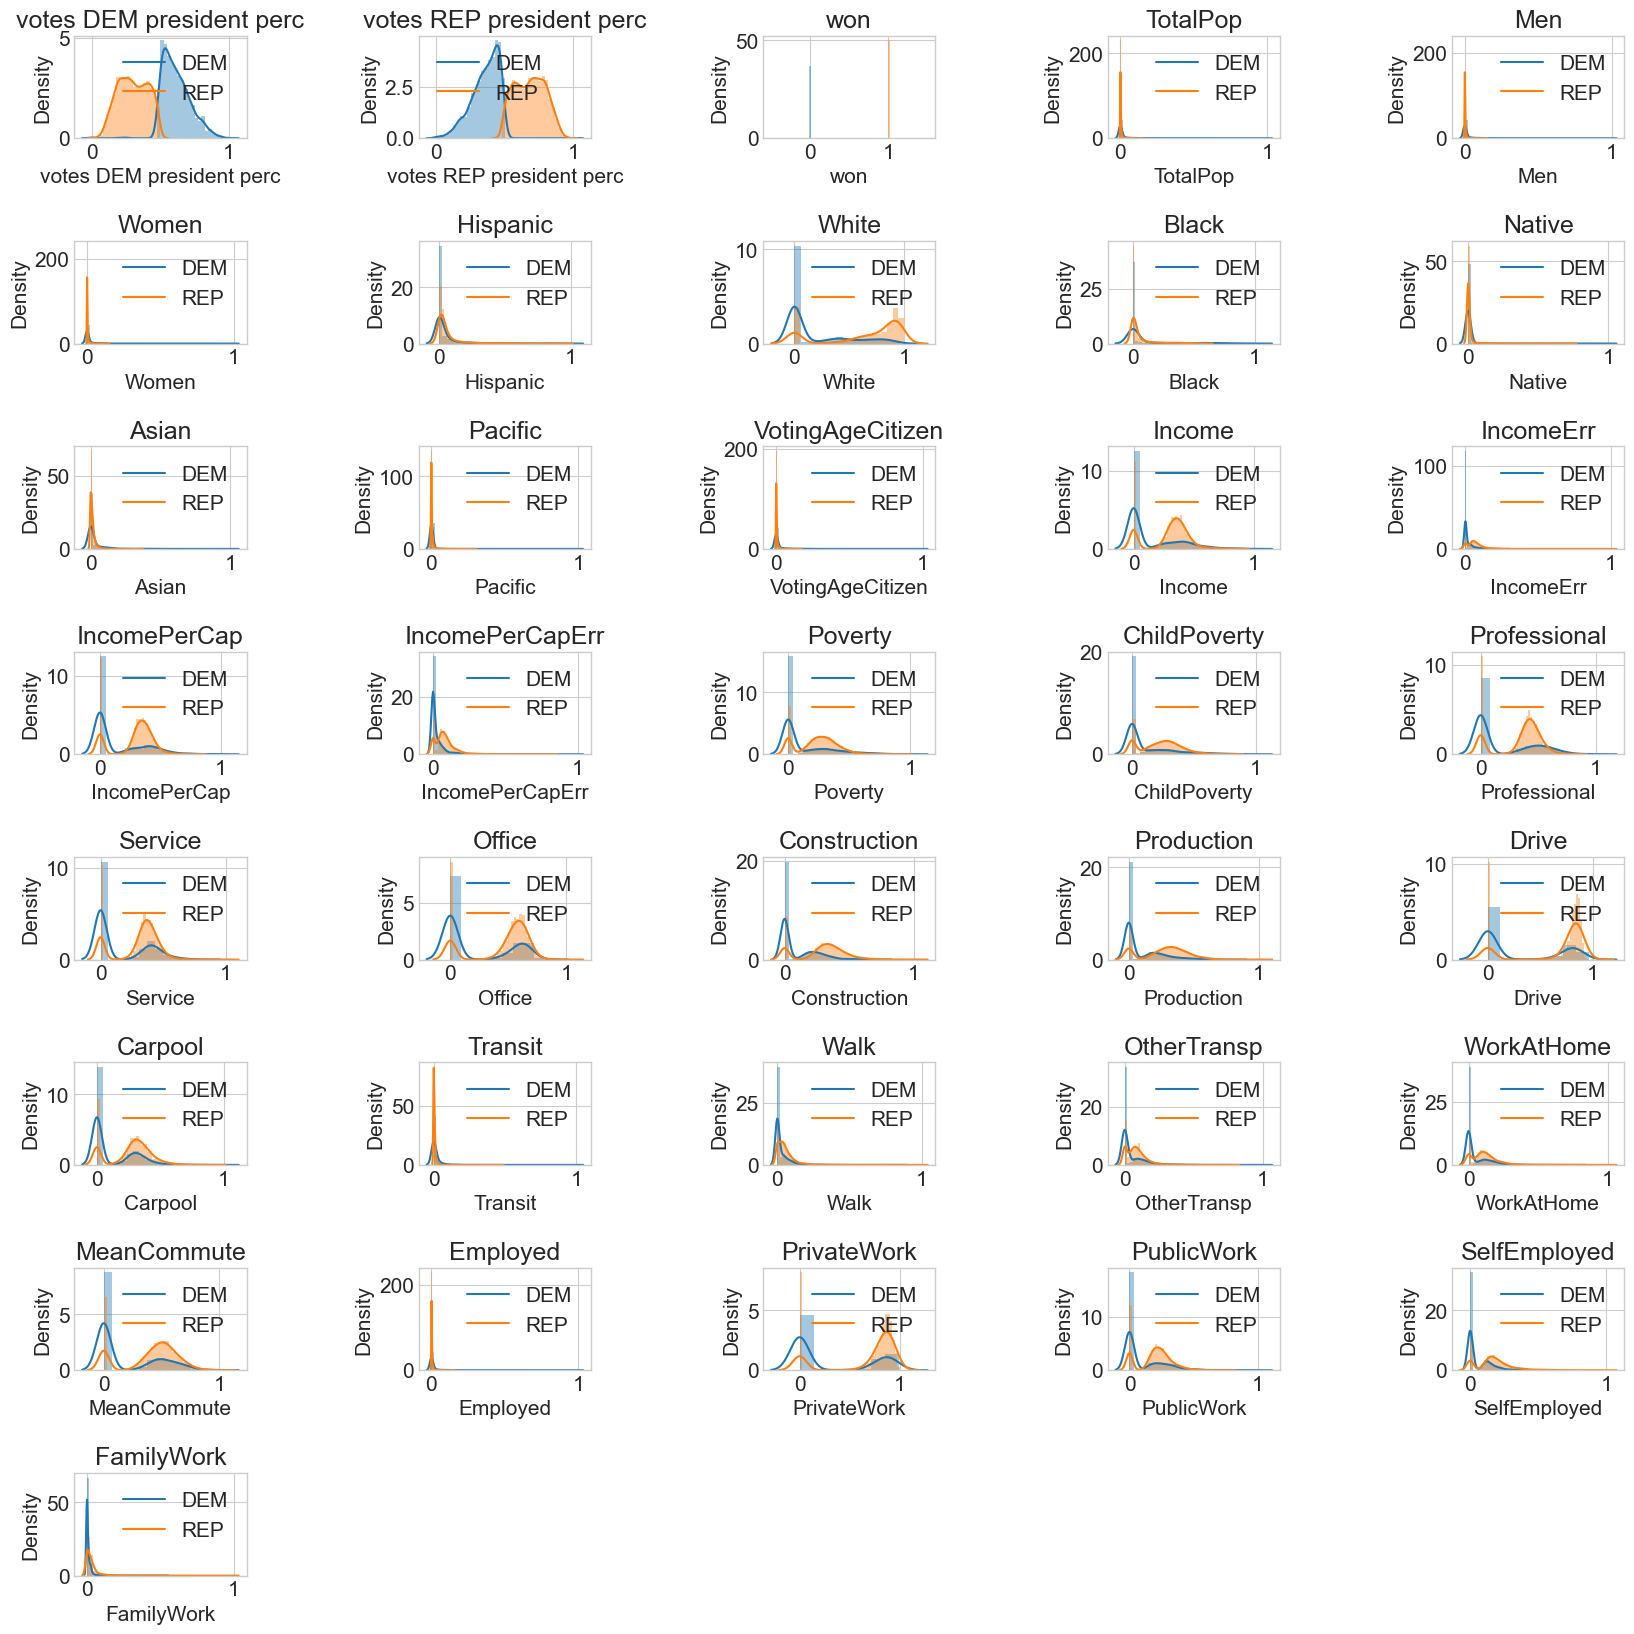

In [37]:
plot_distribution_against_label(df_final, cols=5, width=20, height=20, hspace=1.0, wspace=1.0)

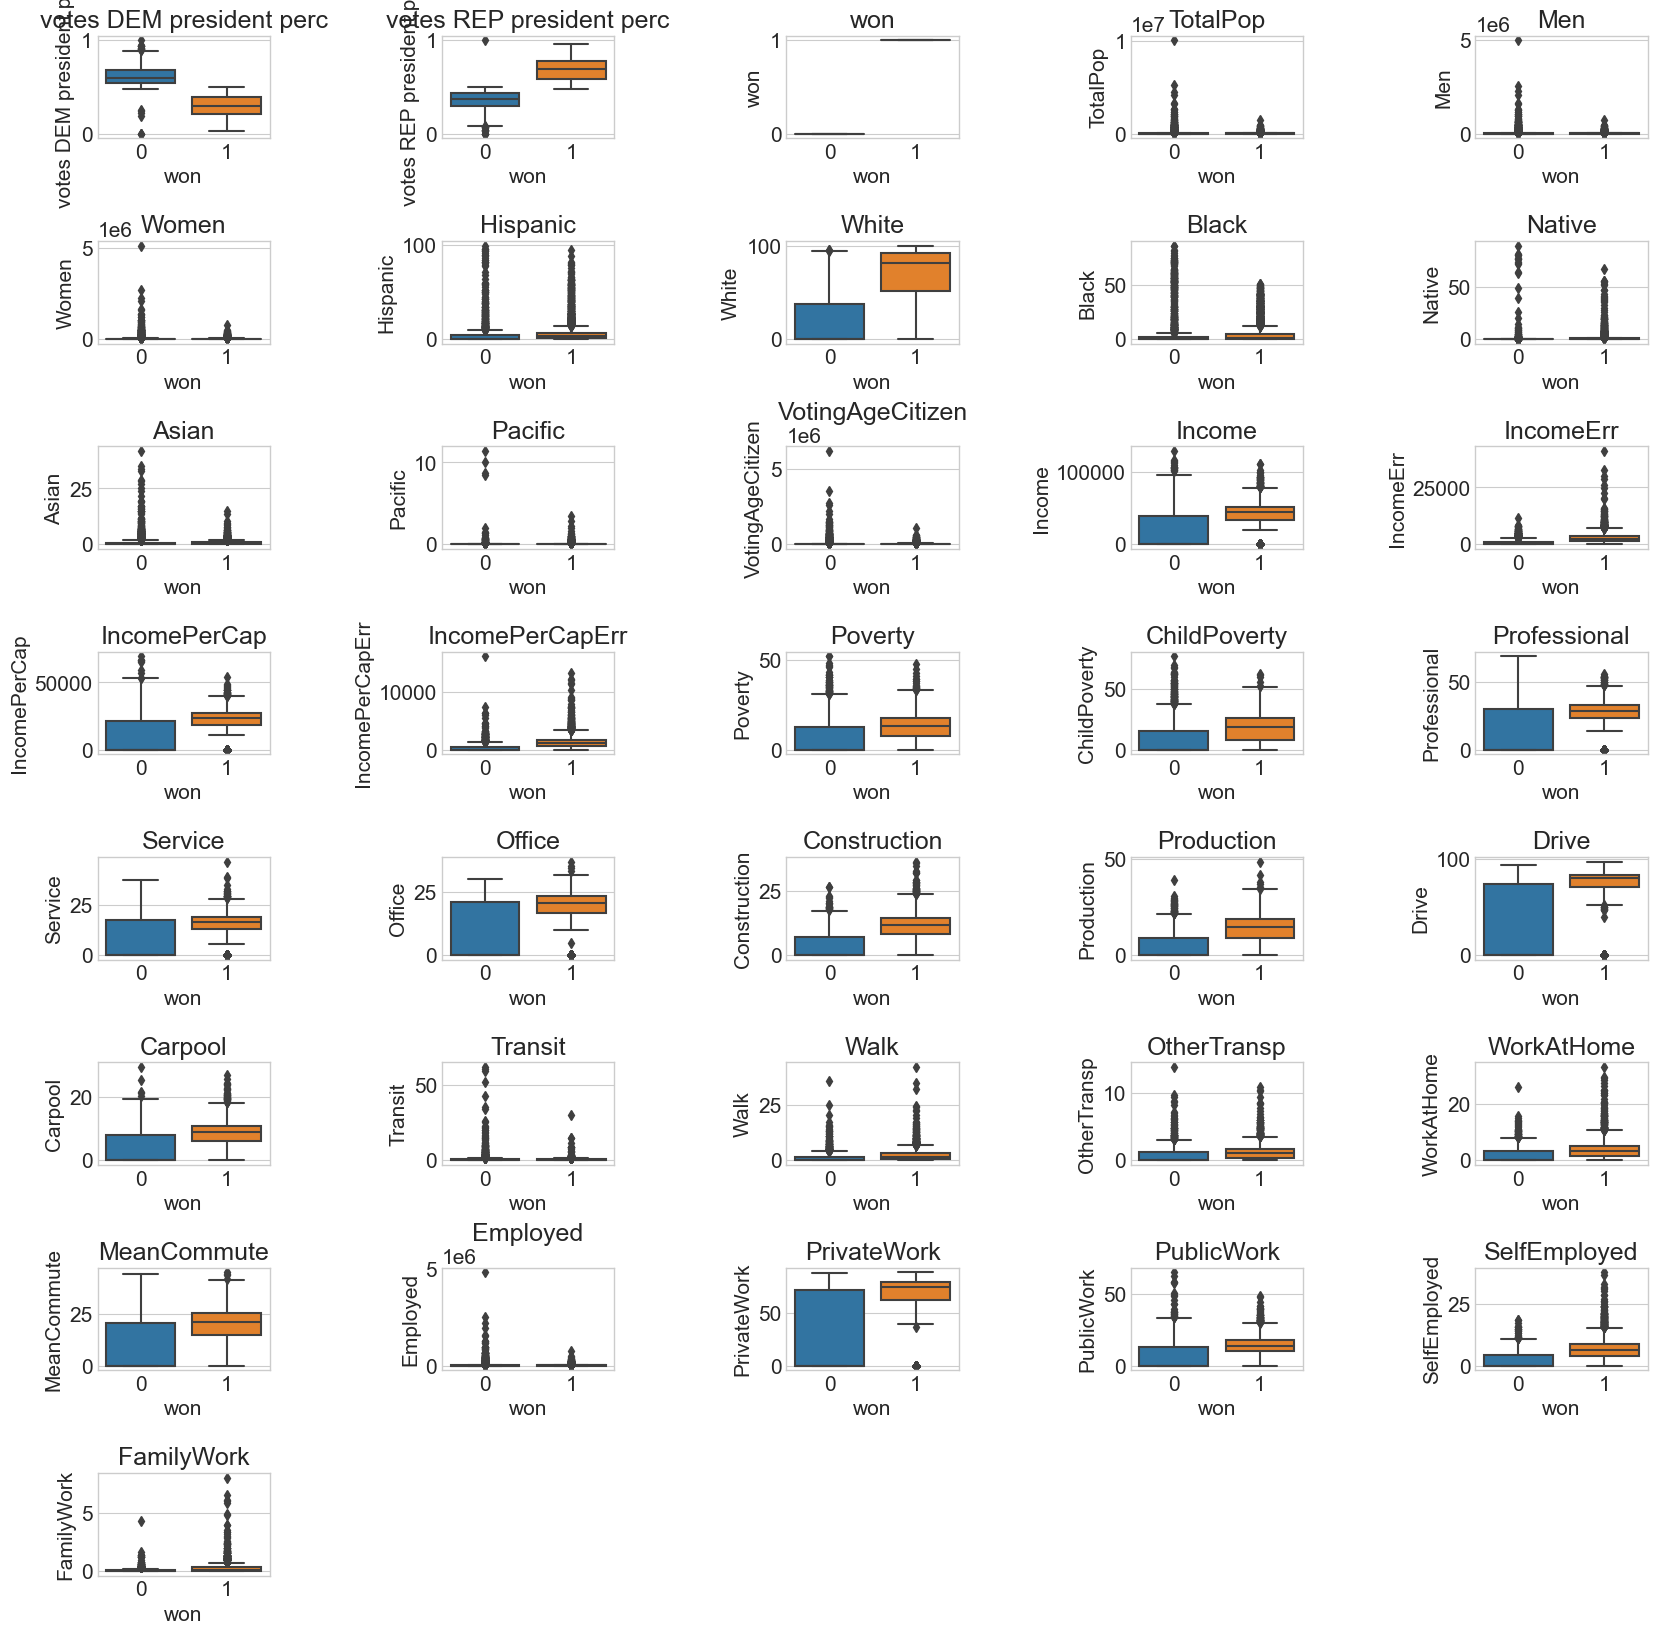

In [38]:
plot_boxplot_against_label(df, cols=5, width=20, height=20, hspace=1.0, wspace=1.0)

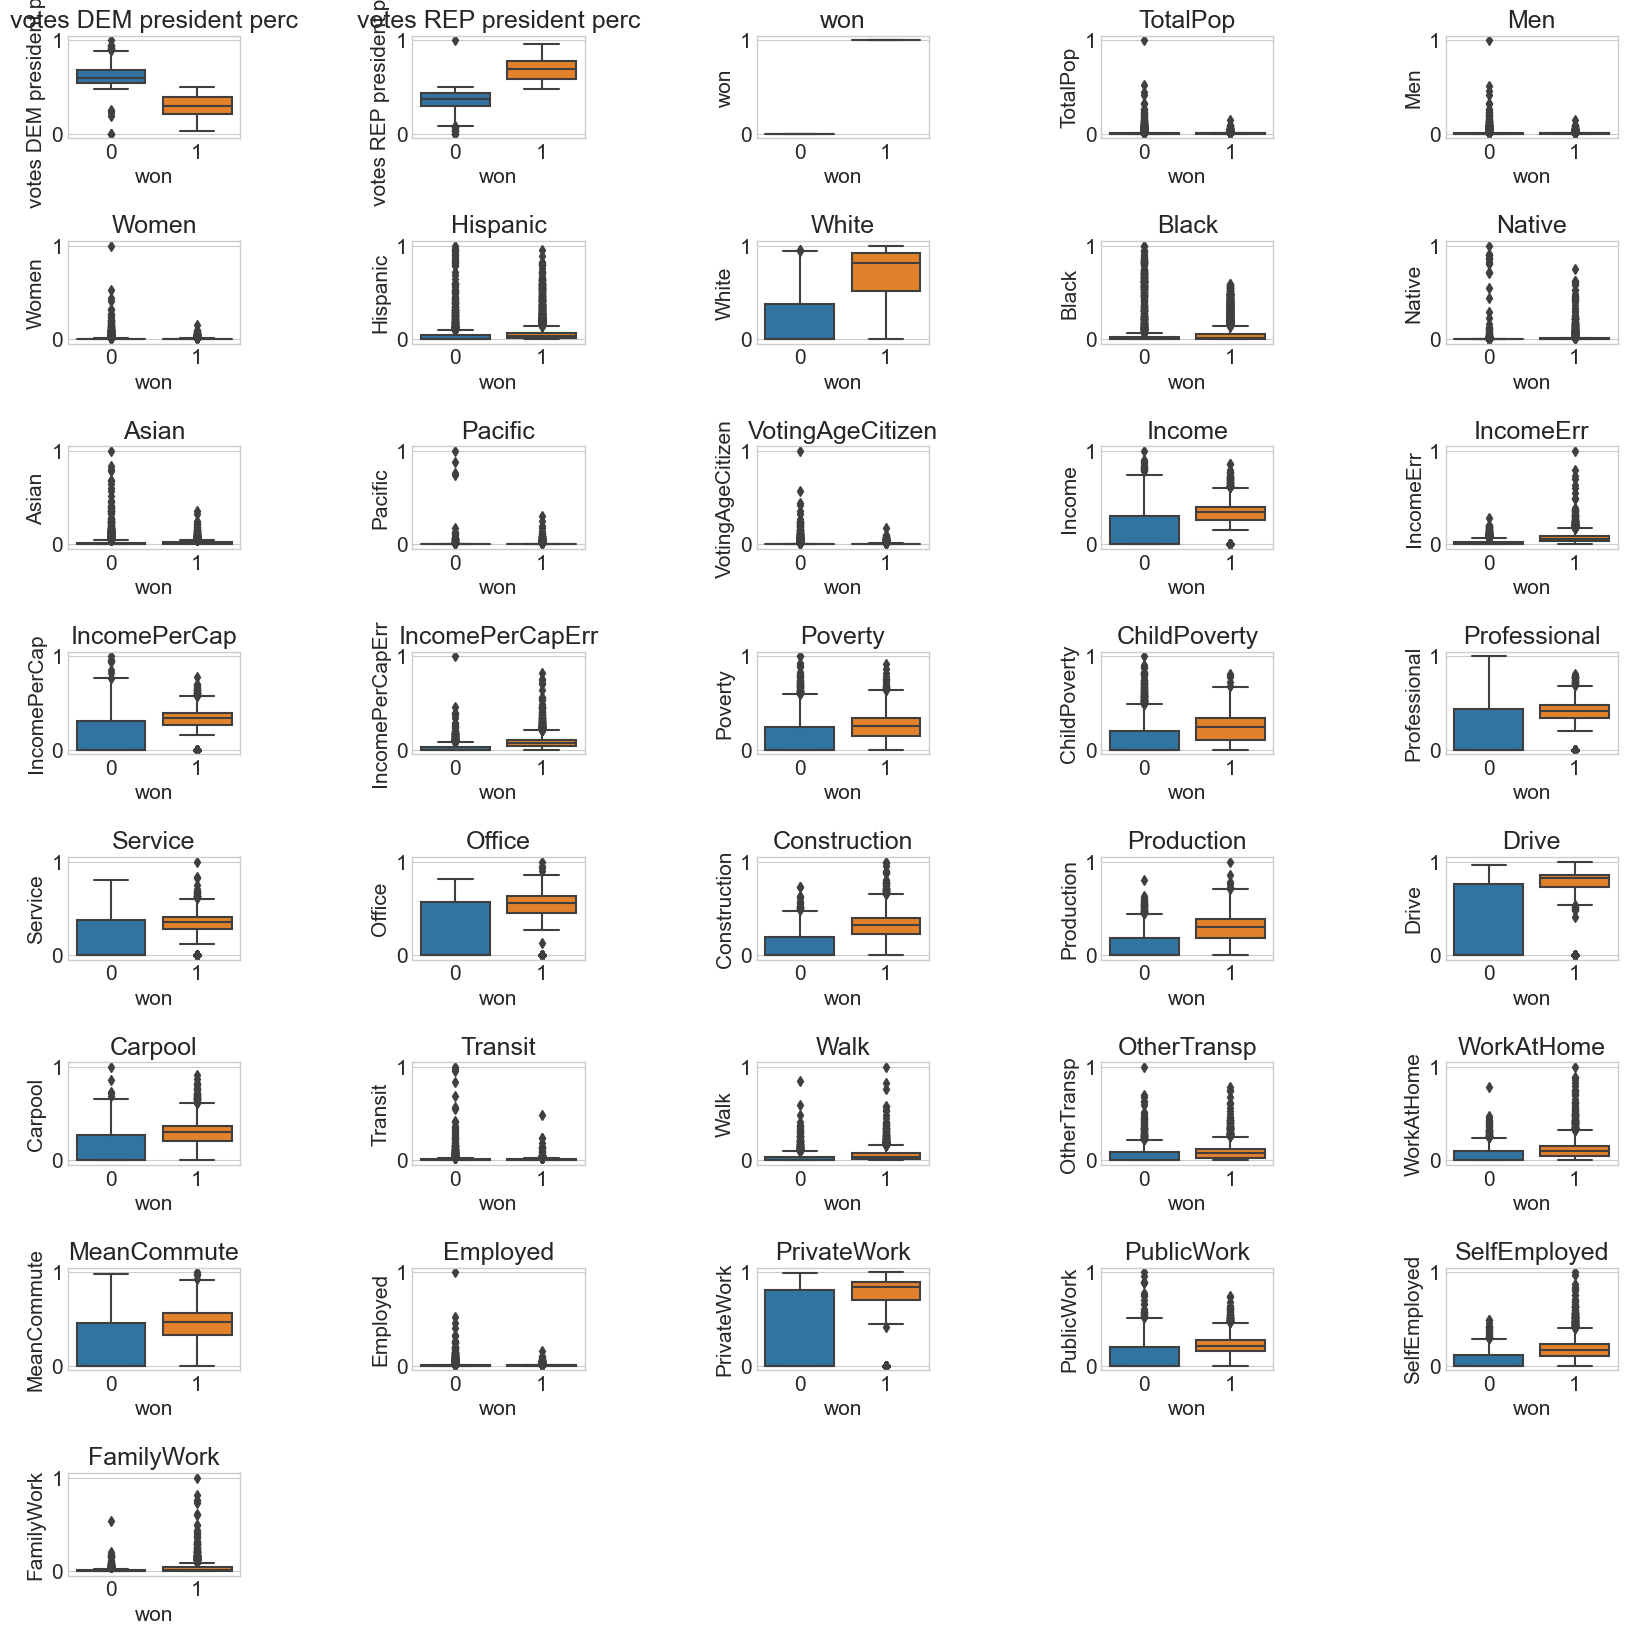

In [39]:
plot_boxplot_against_label(df_final, cols=5, width=20, height=20, hspace=1.0, wspace=1.0)

In [40]:
font = {"family" : "sans serif",
        "size"   : 12}

matplotlib.rc("font", **font)

Text(0.5, 1.0, 'Correlation')

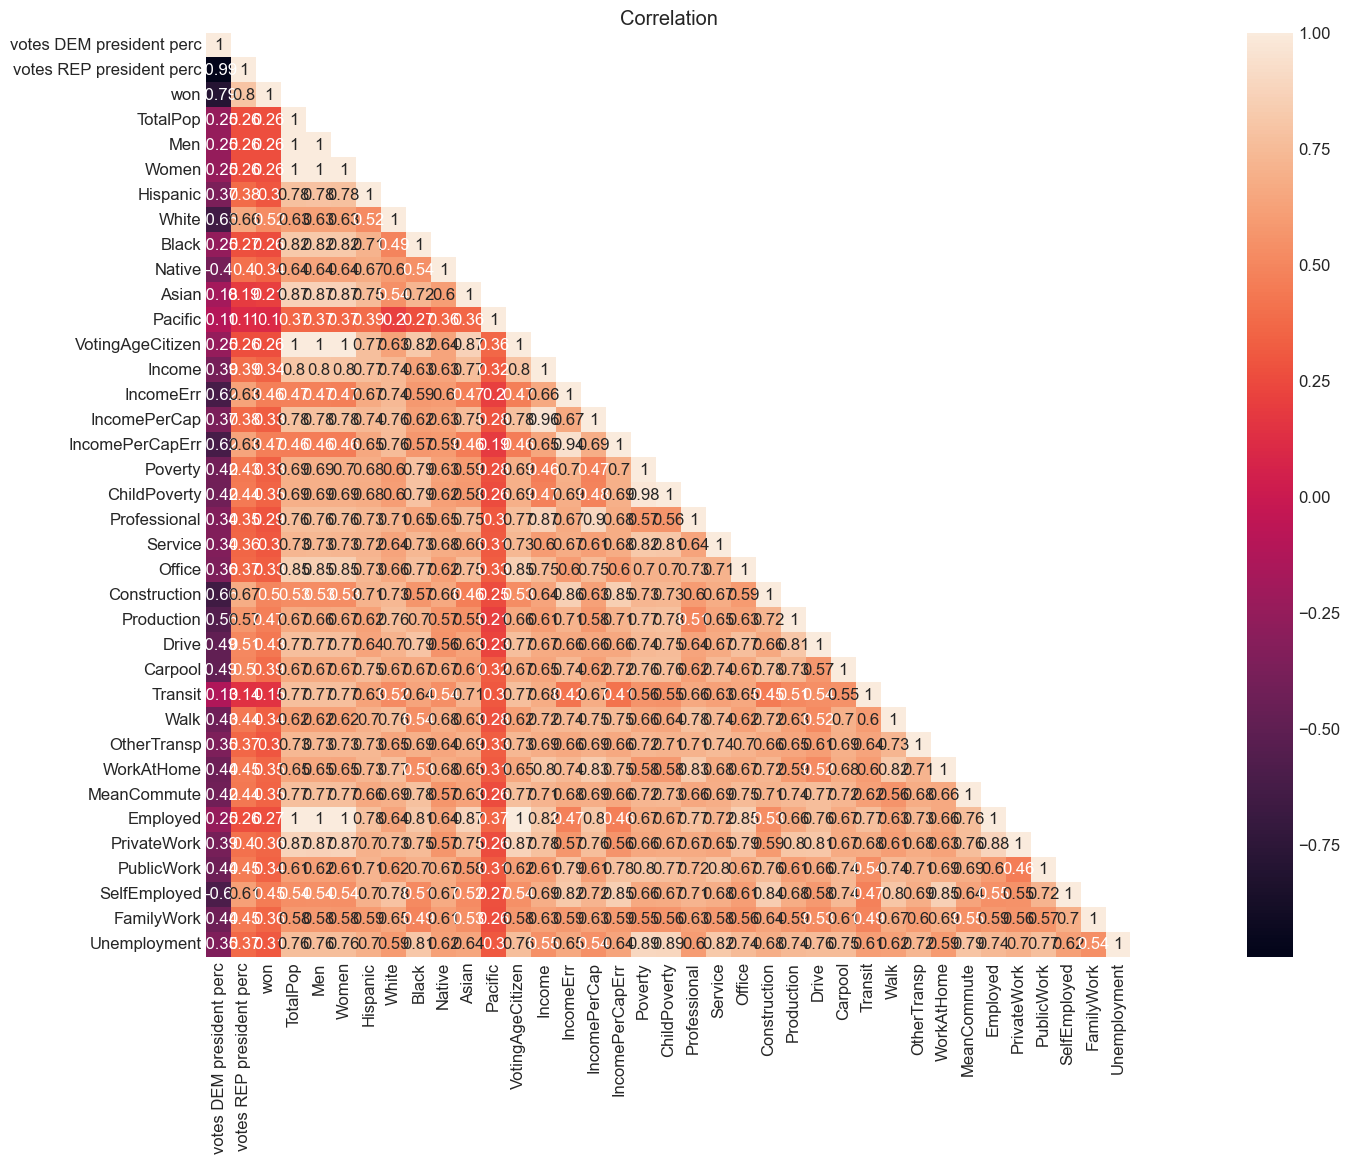

In [41]:
cor_mat= df[:].corr(method="spearman")
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)
plt.title("Correlation")

Text(0.5, 1.0, 'Correlation')

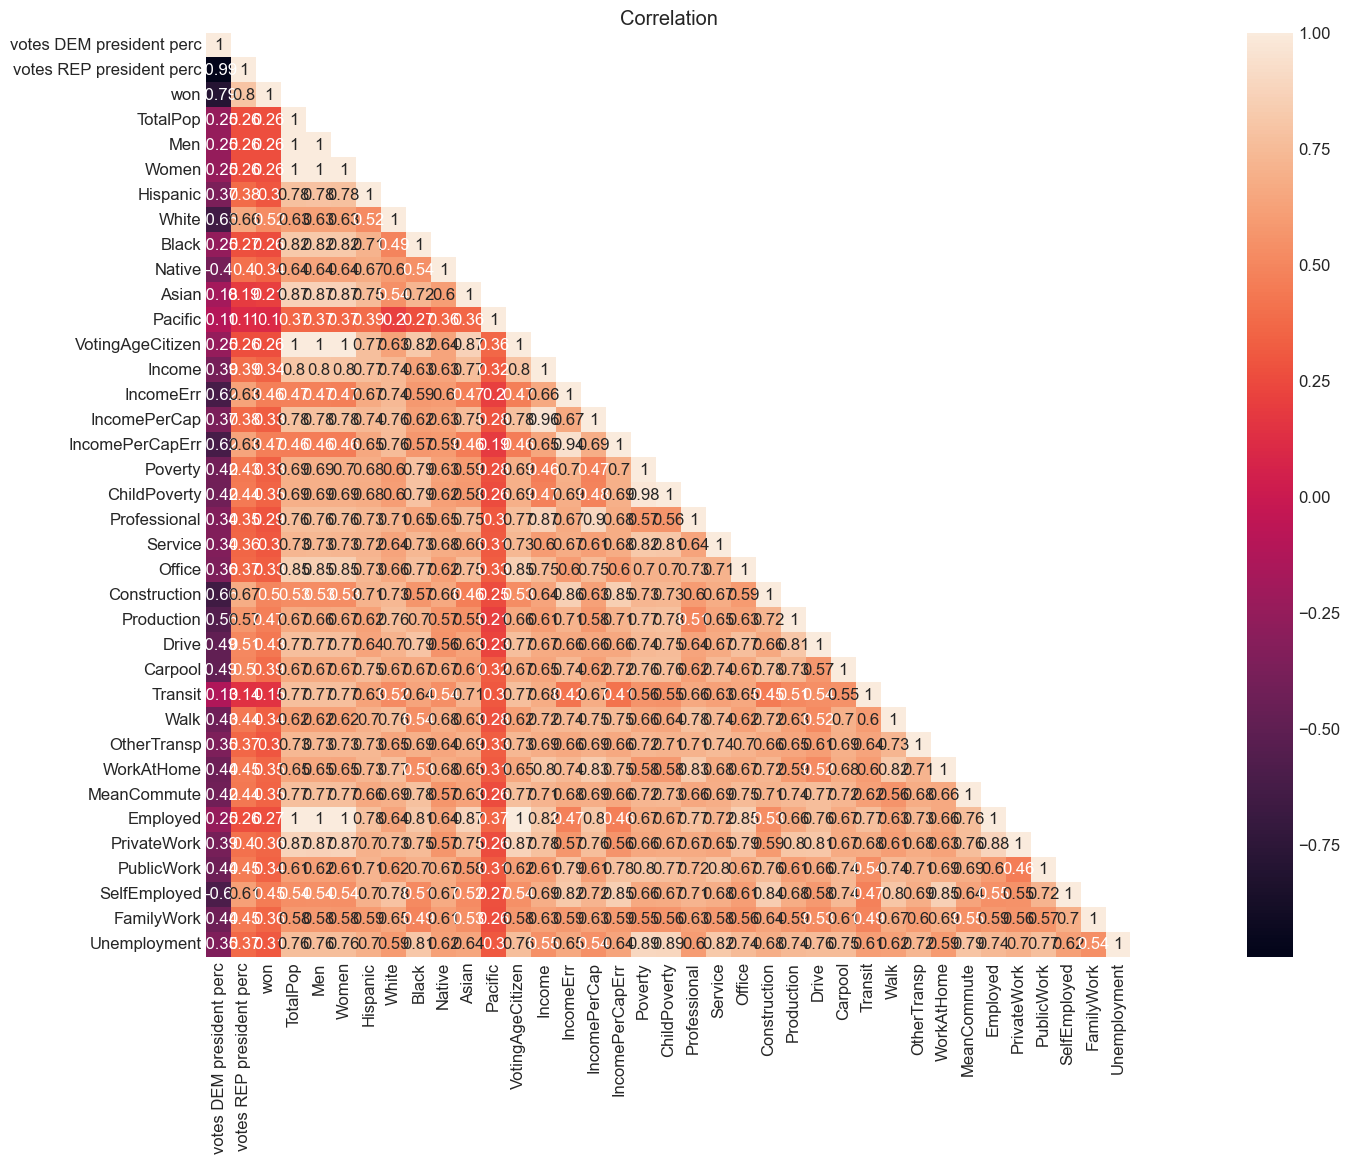

In [42]:
cor_mat= df_final[:].corr(method="spearman")
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)
plt.title("Correlation")

In [43]:
factors

['TotalPop',
 'Men',
 'Women',
 'Hispanic',
 'White',
 'Black',
 'Native',
 'Asian',
 'Pacific',
 'VotingAgeCitizen',
 'Income',
 'IncomeErr',
 'IncomePerCap',
 'IncomePerCapErr',
 'Poverty',
 'ChildPoverty',
 'Professional',
 'Service',
 'Office',
 'Construction',
 'Production',
 'Drive',
 'Carpool',
 'Transit',
 'Walk',
 'OtherTransp',
 'WorkAtHome',
 'MeanCommute',
 'Employed',
 'PrivateWork',
 'PublicWork',
 'SelfEmployed',
 'FamilyWork',
 'Unemployment']

In [44]:
font = {"family" : "sans serif",
        "size"   : 15}

matplotlib.rc("font", **font)

Text(0.5, 21.349999999999998, 'n_components')

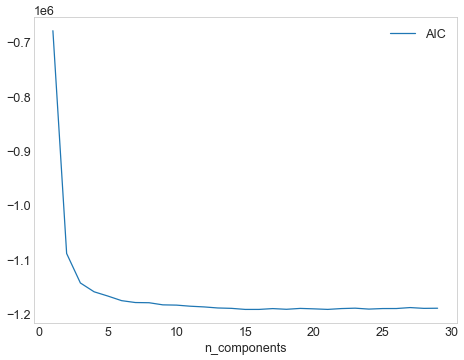

In [45]:
x = df_final[factors].values

gm_n_components = np.arange(1, 30)
gm_models = [mixture.GaussianMixture(n, covariance_type="full", random_state=0).fit(x) for n in gm_n_components]

plt.figure(num=None, figsize=(8, 6), dpi=60, facecolor="w", edgecolor="r")
plt.plot(gm_n_components, [m.aic(x) for m in gm_models], label="AIC")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.xlabel("n_components")

In [46]:
gm_n_classes = 2

gm_cluster = mixture.GaussianMixture(n_components=gm_n_classes, covariance_type="full", random_state=0)
gm_cluster_fit = gm_cluster.fit(df_final)
gm_labels = gm_cluster_fit.predict(df_final)

print("Number of clusters: " + format(len(np.unique(gm_labels))))

Number of clusters: 2


In [47]:
unique, counts = np.unique(gm_labels, return_counts=True)
dict(zip(unique, counts))

{0: 3044, 1: 1589}

In [48]:
#df_final["Party_Cluster"] = gm_labels

In [49]:
df_final["won"]

state    county           
Alabama  Autauga County       1
         Baldwin County       1
         Barbour County       1
         Bibb County          1
         Blount County        1
                             ..
Wyoming  Sweetwater County    1
         Teton County         0
         Uinta County         1
         Washakie County      1
         Weston County        1
Name: won, Length: 4633, dtype: int64

In [50]:
response = pd.DataFrame(df_final["votes REP president perc"]).rename(columns={"votes REP president perc": "Response"})
response

Response
state   county                     
Alabama Autauga County     0.714368
        Baldwin County     0.761714
        Barbour County     0.534512
        Bibb County        0.784263
        Blount County      0.895716
...                             ...
Wyoming Sweetwater County  0.736554
        Teton County       0.295769
        Uinta County       0.797277
        Washakie County    0.808824
        Weston County      0.877188

[4633 rows x 1 columns]

In [51]:
df_final_estimation = df_final.drop(votes, axis=1)

In [52]:
x_train, x_test, y_train, y_test = train_test_split(df_final_estimation, response, test_size=0.2, random_state=0)

In [53]:
model_average = y_train.mean()
print(str(round(model_average, 5)))

Response    0.58412
dtype: float64


In [54]:
rmse = y_test
rmse.insert(1, "Model_Average", model_average.values[0], True)
y_test=y_test.drop(["Model_Average"], axis=1)
rmse

Response  Model_Average
state          county                                    
Texas          Uvalde County      0.596983       0.584122
Indiana        Porter County      0.520270       0.584122
Massachusetts  Great Barrington   0.159047       0.584122
California     Mariposa County    0.578794       0.584122
Georgia        Burke County       0.505476       0.584122
...                                    ...            ...
Oregon         Hood River County  0.302139       0.584122
North Carolina Madison County     0.610202       0.584122
Massachusetts  Charlemont         0.316285       0.584122
Indiana        Warrick County     0.630406       0.584122
Maine          Ellsworth          0.489013       0.584122

[927 rows x 2 columns]

In [55]:
model_glm = sm.GLM(y_train, x_train, family=sm.families.Gaussian())

model_glm_fit = model_glm.fit()

print(model_glm_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Response   No. Observations:                 3706
Model:                            GLM   Df Residuals:                     3673
Model Family:                Gaussian   Df Model:                           32
Link Function:               identity   Scale:                        0.079701
Method:                          IRLS   Log-Likelihood:                -554.90
Date:                Wed, 01 Feb 2023   Deviance:                       292.74
Time:                        00:22:29   Pearson chi2:                     293.
No. Iterations:                     4   Pseudo R-squ. (CS):            -0.7653
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
TotalPop             0.2515      1.343  

In [56]:
rmse.insert(2, "Model_GLM", model_glm_fit.predict(x_test).values, True)

In [57]:
space={"max_depth": hp.quniform("max_depth", 2,25,1),
      "alpha": hp.uniform ("alpha", 0,1),
      "colsample_bytree" : hp.uniform("colsample_bytree", 0.5,1),
      "min_child_weight" : hp.quniform("min_child_weight", 0, 25, 1),
      "learning_rate" : hp.uniform("learning_rate", 0.00001, 0.8),
      "n_estimators": 500,
      "seed": 0}

def f_rmse(predictions, targets):
    return np.sqrt(np.mean((predictions - targets) ** 2))

def objective(space):
    clf = xgb.XGBRegressor(objective ="reg:squarederror",n_estimators =space["n_estimators"], max_depth=int(space["max_depth"]), alpha=space["alpha"],
                           learning_rate = space["learning_rate"],min_child_weight=space["min_child_weight"],colsample_bytree=space["colsample_bytree"])

    evaluation = [(x_train, y_train), (x_test, y_test)]
    
    clf_fit = clf.fit(x_train, y_train, verbose=False, eval_set=evaluation, early_stopping_rounds=20)
    
    pred = clf_fit.predict(x_test)
    score = f_rmse(rmse["Response"].values, pred)
    print(format(score))
    return {"loss": score, "status": STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

0.10756158507864269                                    
0.11378890898274922                                                               
0.11150168639199134                                                               
0.1108765175368297                                                                
0.11104889339308038                                                               
0.10695118747655587                                                               
0.10948822334444383                                                               
0.10934274939934537                                                               
0.11475640222008768                                                               
0.10743645230774164                                                               
0.11019535861437342                                                                
0.1119027661816341                                                                 
0.10794069480624699          

In [58]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'alpha': 0.6049546025034077, 'colsample_bytree': 0.6622447309988748, 'learning_rate': 0.0792584357526886, 'max_depth': 12.0, 'min_child_weight': 8.0}


In [59]:
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.7039322476687809, learning_rate=0.0755106329787689,
                             max_depth=15, alpha=0.5386629916569763, n_estimators=300, min_child_weight=17)

model_xgb_fit = model_xgb.fit(x_train, y_train)

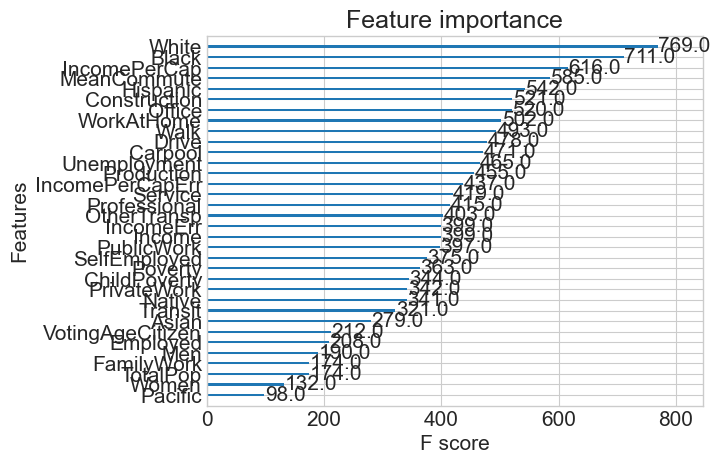

In [60]:
xgb.plot_importance(model_xgb_fit)
plt.rcParams['figure.figsize'] = [24, 20]
plt.show()

In [61]:
rmse.insert(3, 'Model_XGB', model_xgb_fit.predict(x_test), True)
rmse

Response  Model_Average  Model_GLM  \
state          county                                                  
Texas          Uvalde County      0.596983       0.584122   0.646014   
Indiana        Porter County      0.520270       0.584122   0.603054   
Massachusetts  Great Barrington   0.159047       0.584122   0.000000   
California     Mariposa County    0.578794       0.584122   0.429897   
Georgia        Burke County       0.505476       0.584122   0.582224   
...                                    ...            ...        ...   
Oregon         Hood River County  0.302139       0.584122   0.635802   
North Carolina Madison County     0.610202       0.584122   0.726658   
Massachusetts  Charlemont         0.316285       0.584122   0.000000   
Indiana        Warrick County     0.630406       0.584122   0.665863   
Maine          Ellsworth          0.489013       0.584122   0.000000   

                                  Model_XGB  
state          county                        
Texas          Uvalde County       0.595664  
Indiana        Porter County       0.608162  
Massachusetts  Great Barrington    0.444856  
California     Mariposa County     0.350857  
Georgia        Burke County        0.525130  
...                                     ...  
Oregon         Hood River County   0.552579  
North Carolina Madison County      0.731095  
Massachusetts  Charlemont          0.444856  
Indiana        Warrick County      0.685573  
Maine          Ellsworth           0.444856  

[927 rows x 4 columns]

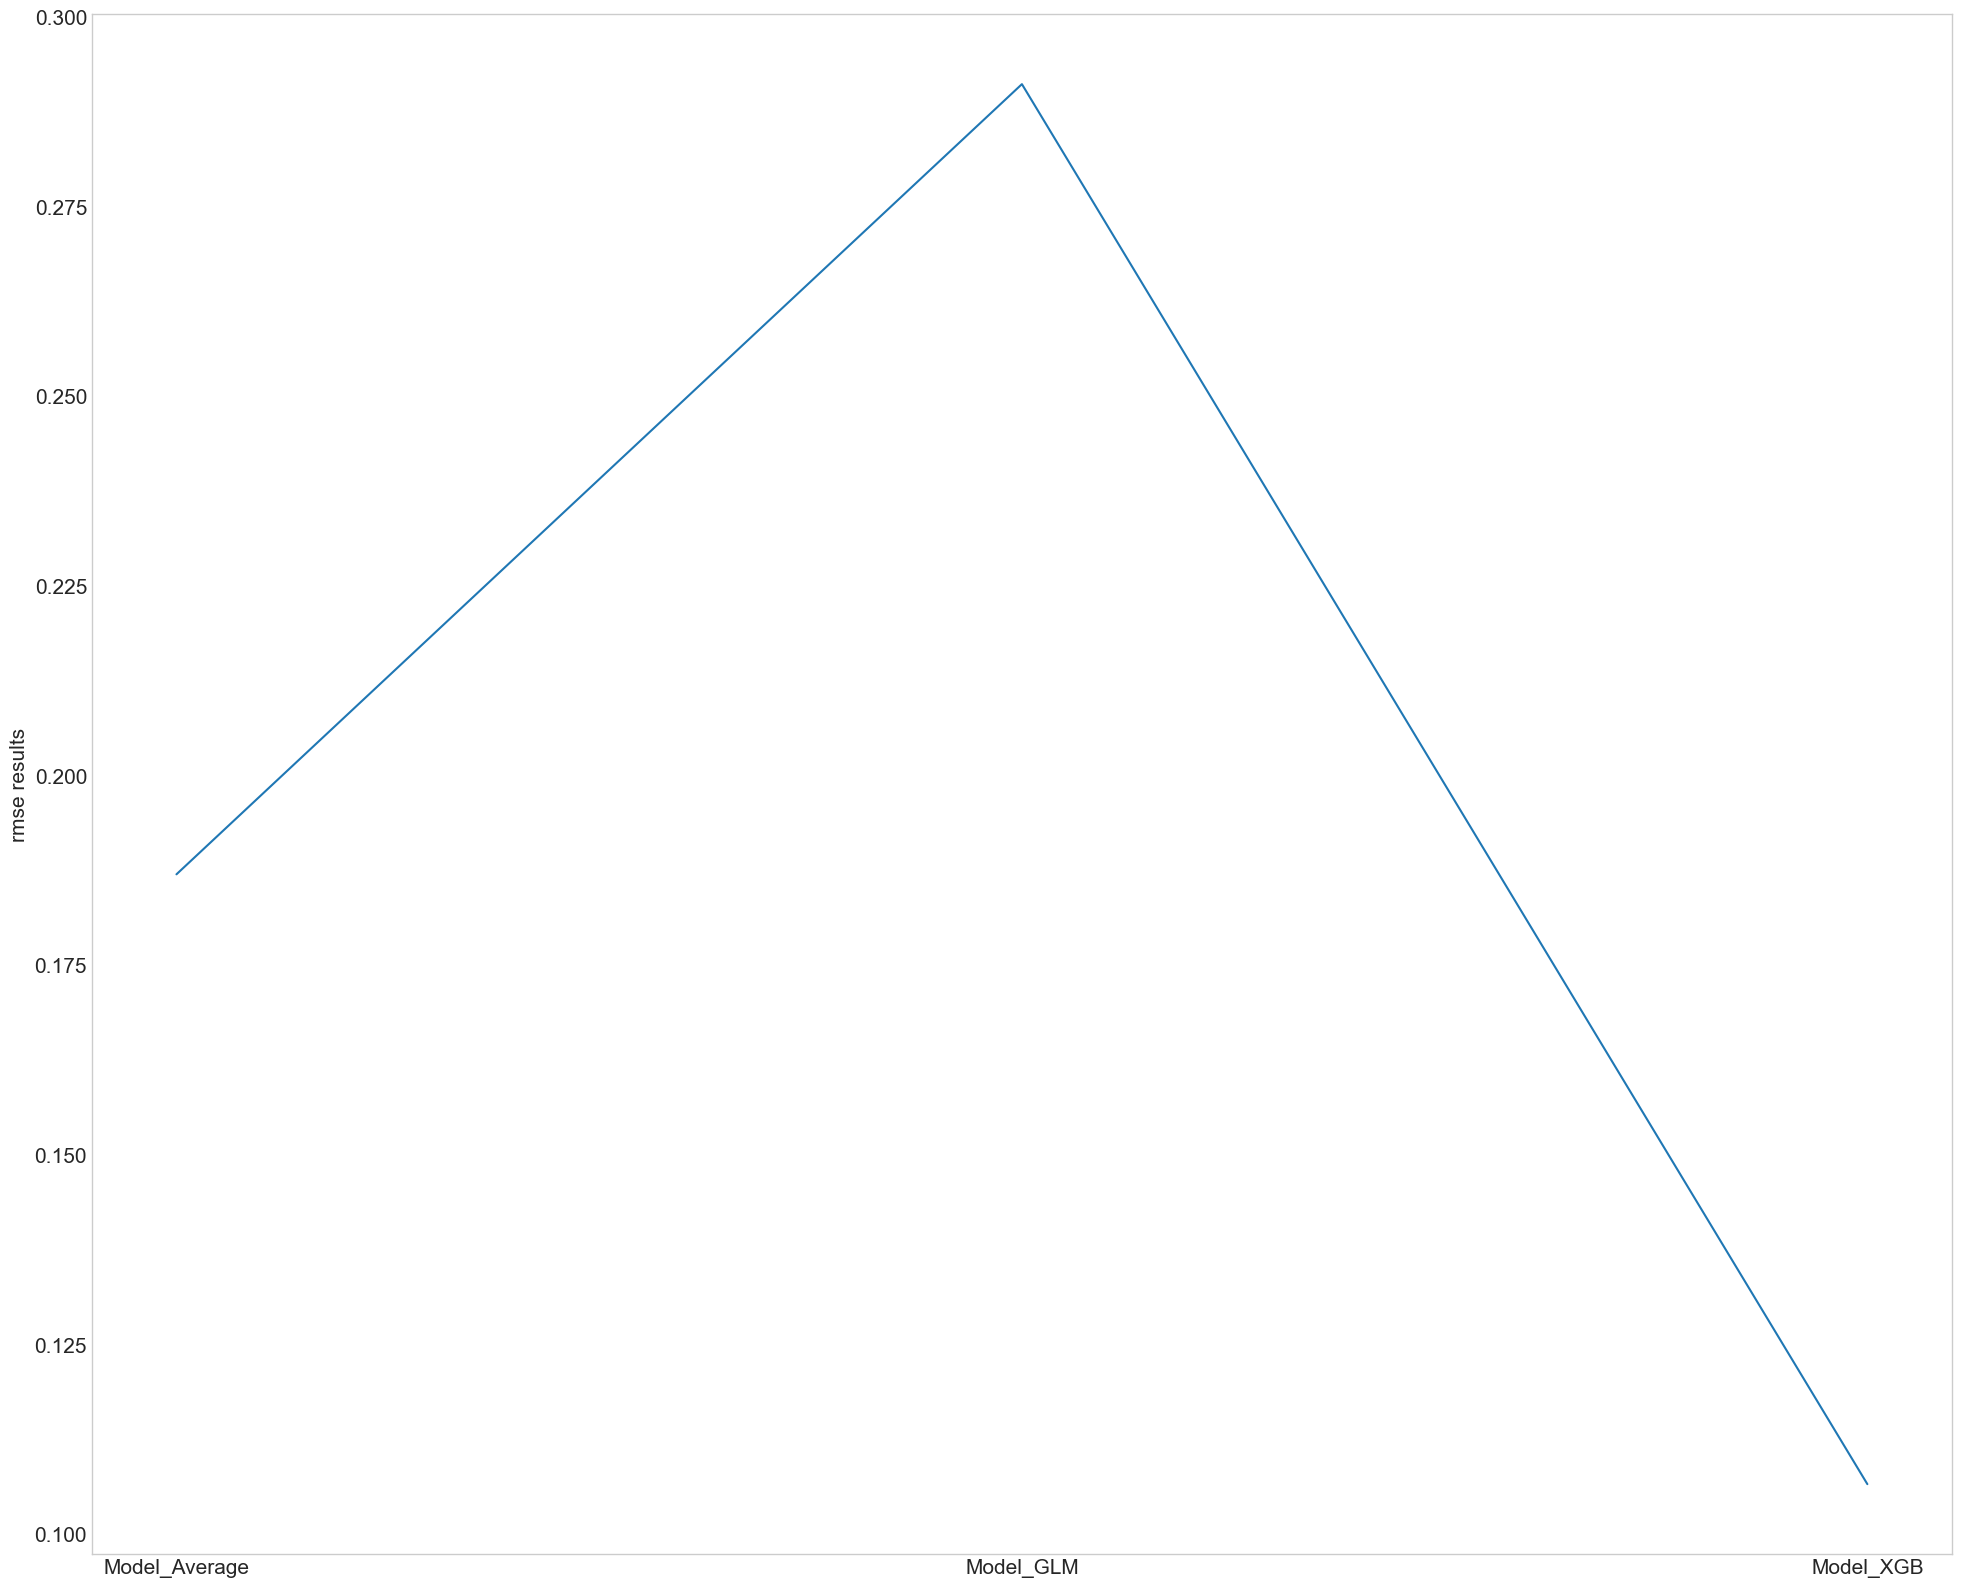

In [62]:
model_average_rmse = f_rmse(rmse["Response"].values, rmse["Model_Average"].values)   
model_glm_rmse = f_rmse(rmse["Response"].values, rmse["Model_GLM"].values)    
model_xgb_rmse = f_rmse(rmse["Response"].values, rmse["Model_XGB"].values)  

results = pd.DataFrame({"rmse": [model_average_rmse,model_glm_rmse,model_xgb_rmse],"Name": ["Model_Average","Model_GLM","Model_XGB"]})
results = results.set_index("Name")

plt.plot(results)
plt.ylabel("rmse results")
plt.grid()
plt.show()

In [63]:
response = pd.DataFrame(df_final["won"]).rename(columns={"won": "Response"})
response

Response
state   county                     
Alabama Autauga County            1
        Baldwin County            1
        Barbour County            1
        Bibb County               1
        Blount County             1
...                             ...
Wyoming Sweetwater County         1
        Teton County              0
        Uinta County              1
        Washakie County           1
        Weston County             1

[4633 rows x 1 columns]

In [64]:
x_train, x_test, y_train, y_test = train_test_split(df_final_estimation, response, test_size=0.2, random_state=0, stratify=response)

In [65]:
logistic_regression = LogisticRegression(random_state=0)
logistic_regression.fit(x_train, y_train)
y_pred = logistic_regression.predict(x_test)

In [66]:
print(metrics.classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.63      0.88      0.73       283
           1       0.94      0.77      0.85       644

    accuracy                           0.81       927
   macro avg       0.78      0.83      0.79       927
weighted avg       0.84      0.81      0.81       927



<BarContainer object of 34 artists>

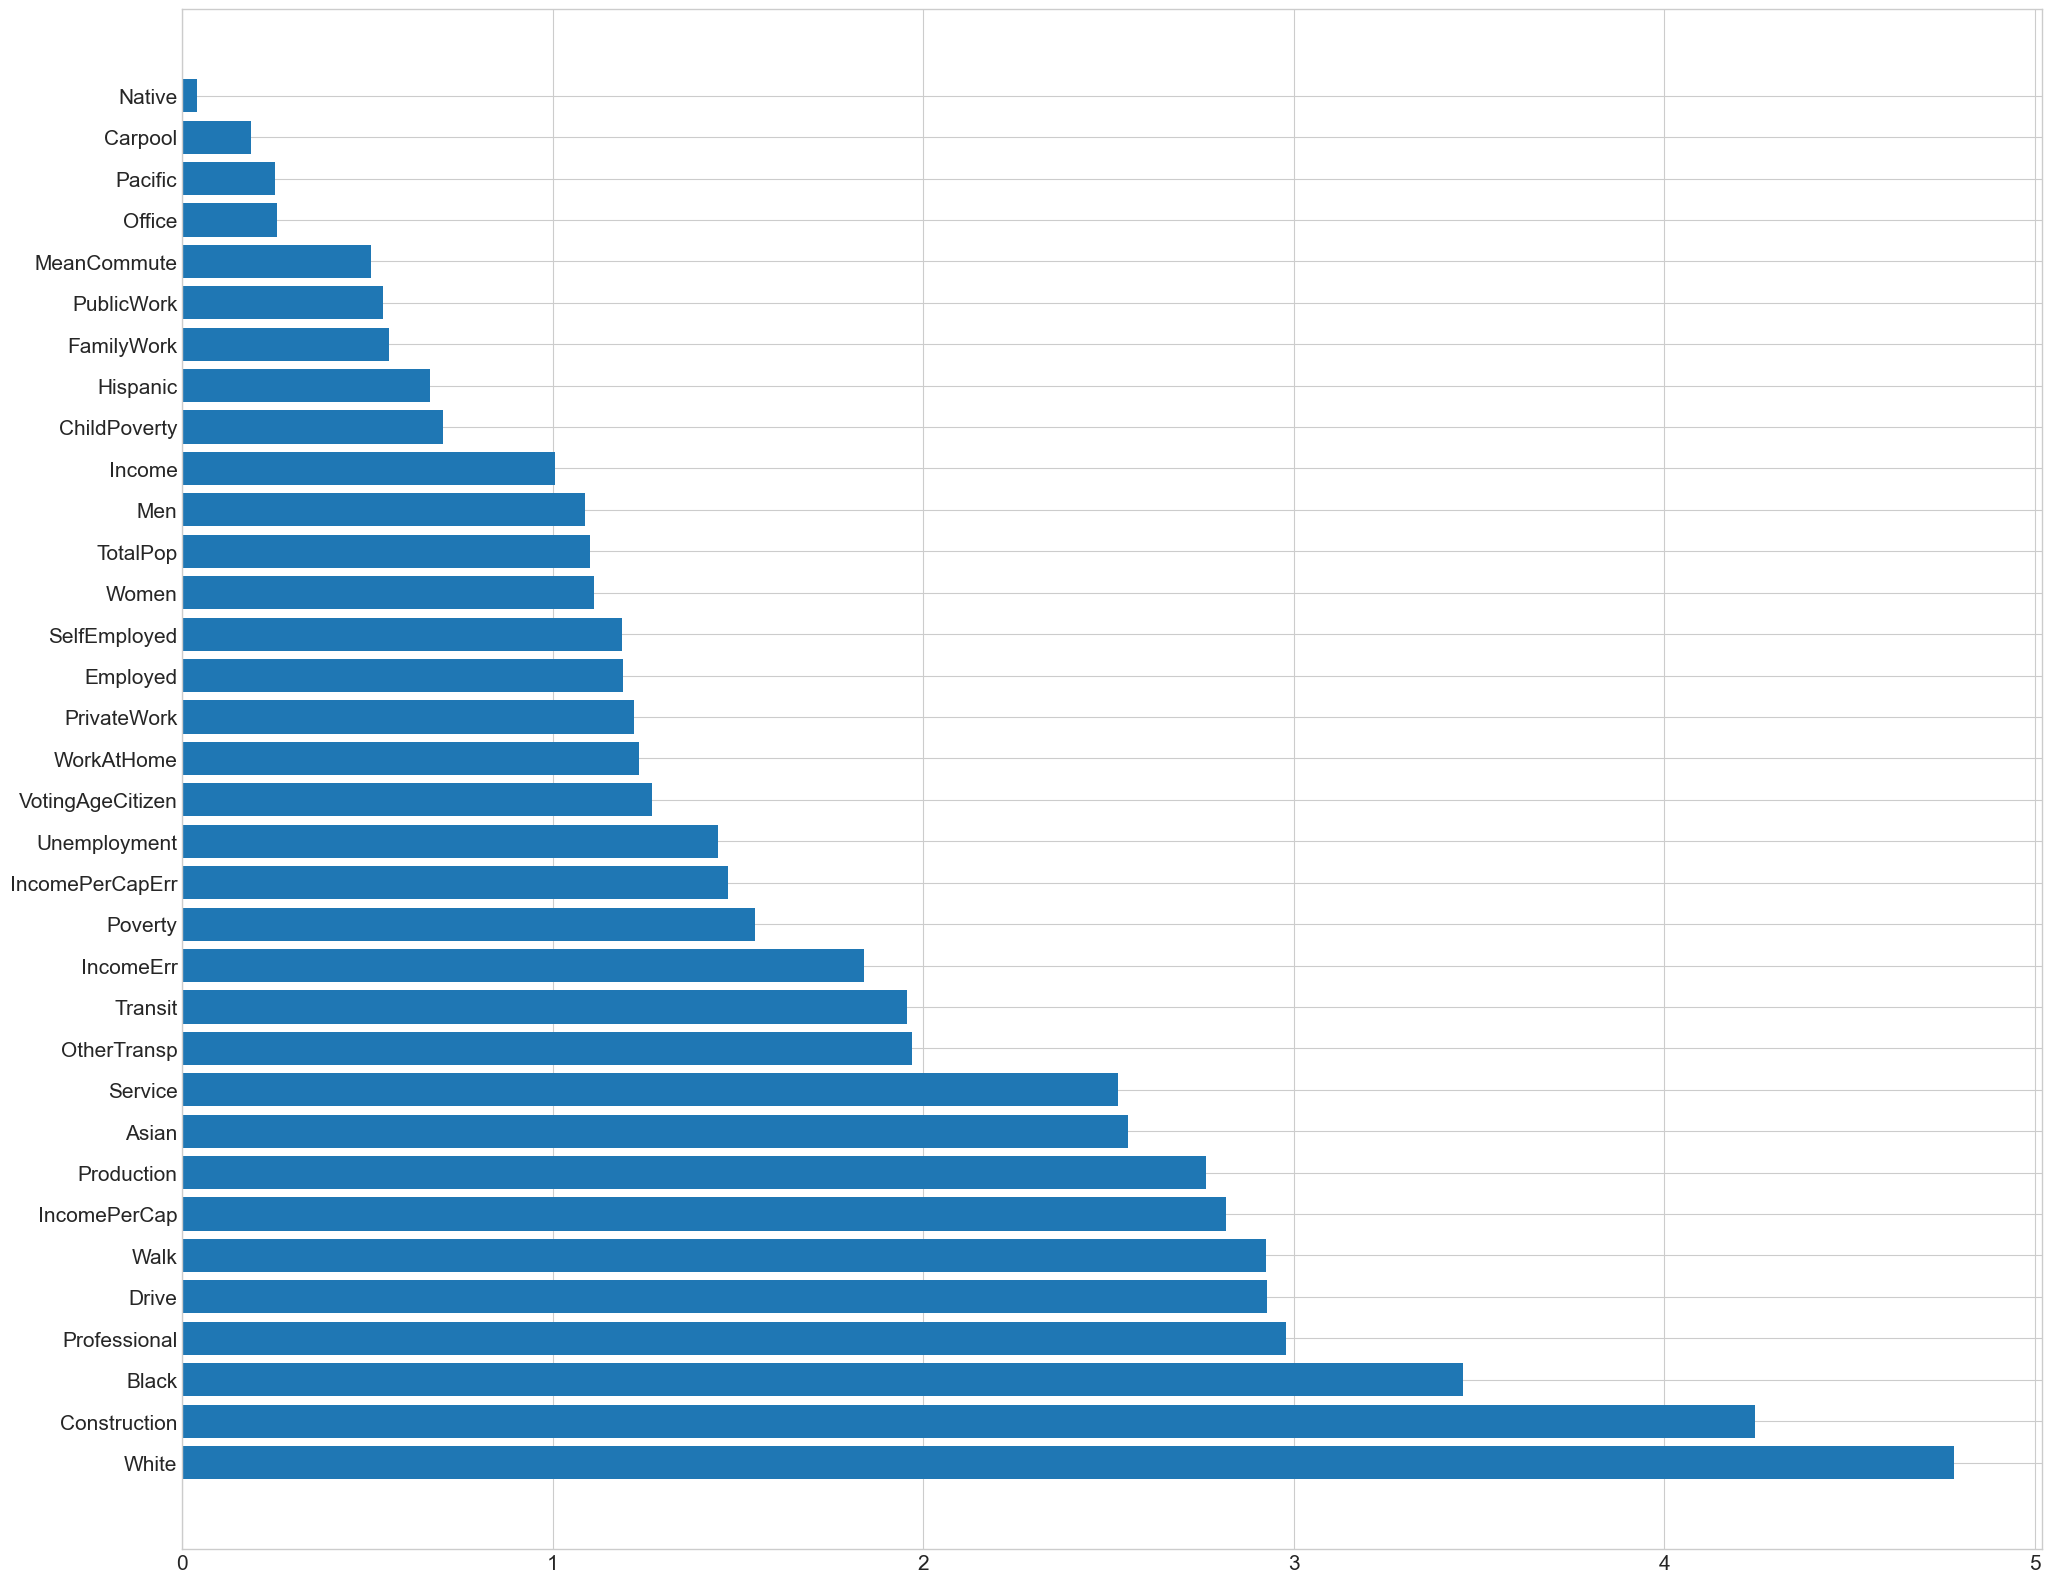

In [67]:
factor_to_weights = dict(zip(list(df_final_estimation.columns), logistic_regression.coef_[0].tolist()))
factor_to_weights = dict(sorted(factor_to_weights.items(), key=lambda x: abs(x[1]), reverse=True))
plt.barh(list(factor_to_weights.keys()), list(map(lambda x: abs(x), factor_to_weights.values())))

In [68]:
random_forest = RandomForestClassifier(1000)
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)

In [69]:
print(metrics.classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.64      0.91      0.75       283
           1       0.95      0.77      0.85       644

    accuracy                           0.81       927
   macro avg       0.79      0.84      0.80       927
weighted avg       0.85      0.81      0.82       927



<BarContainer object of 34 artists>

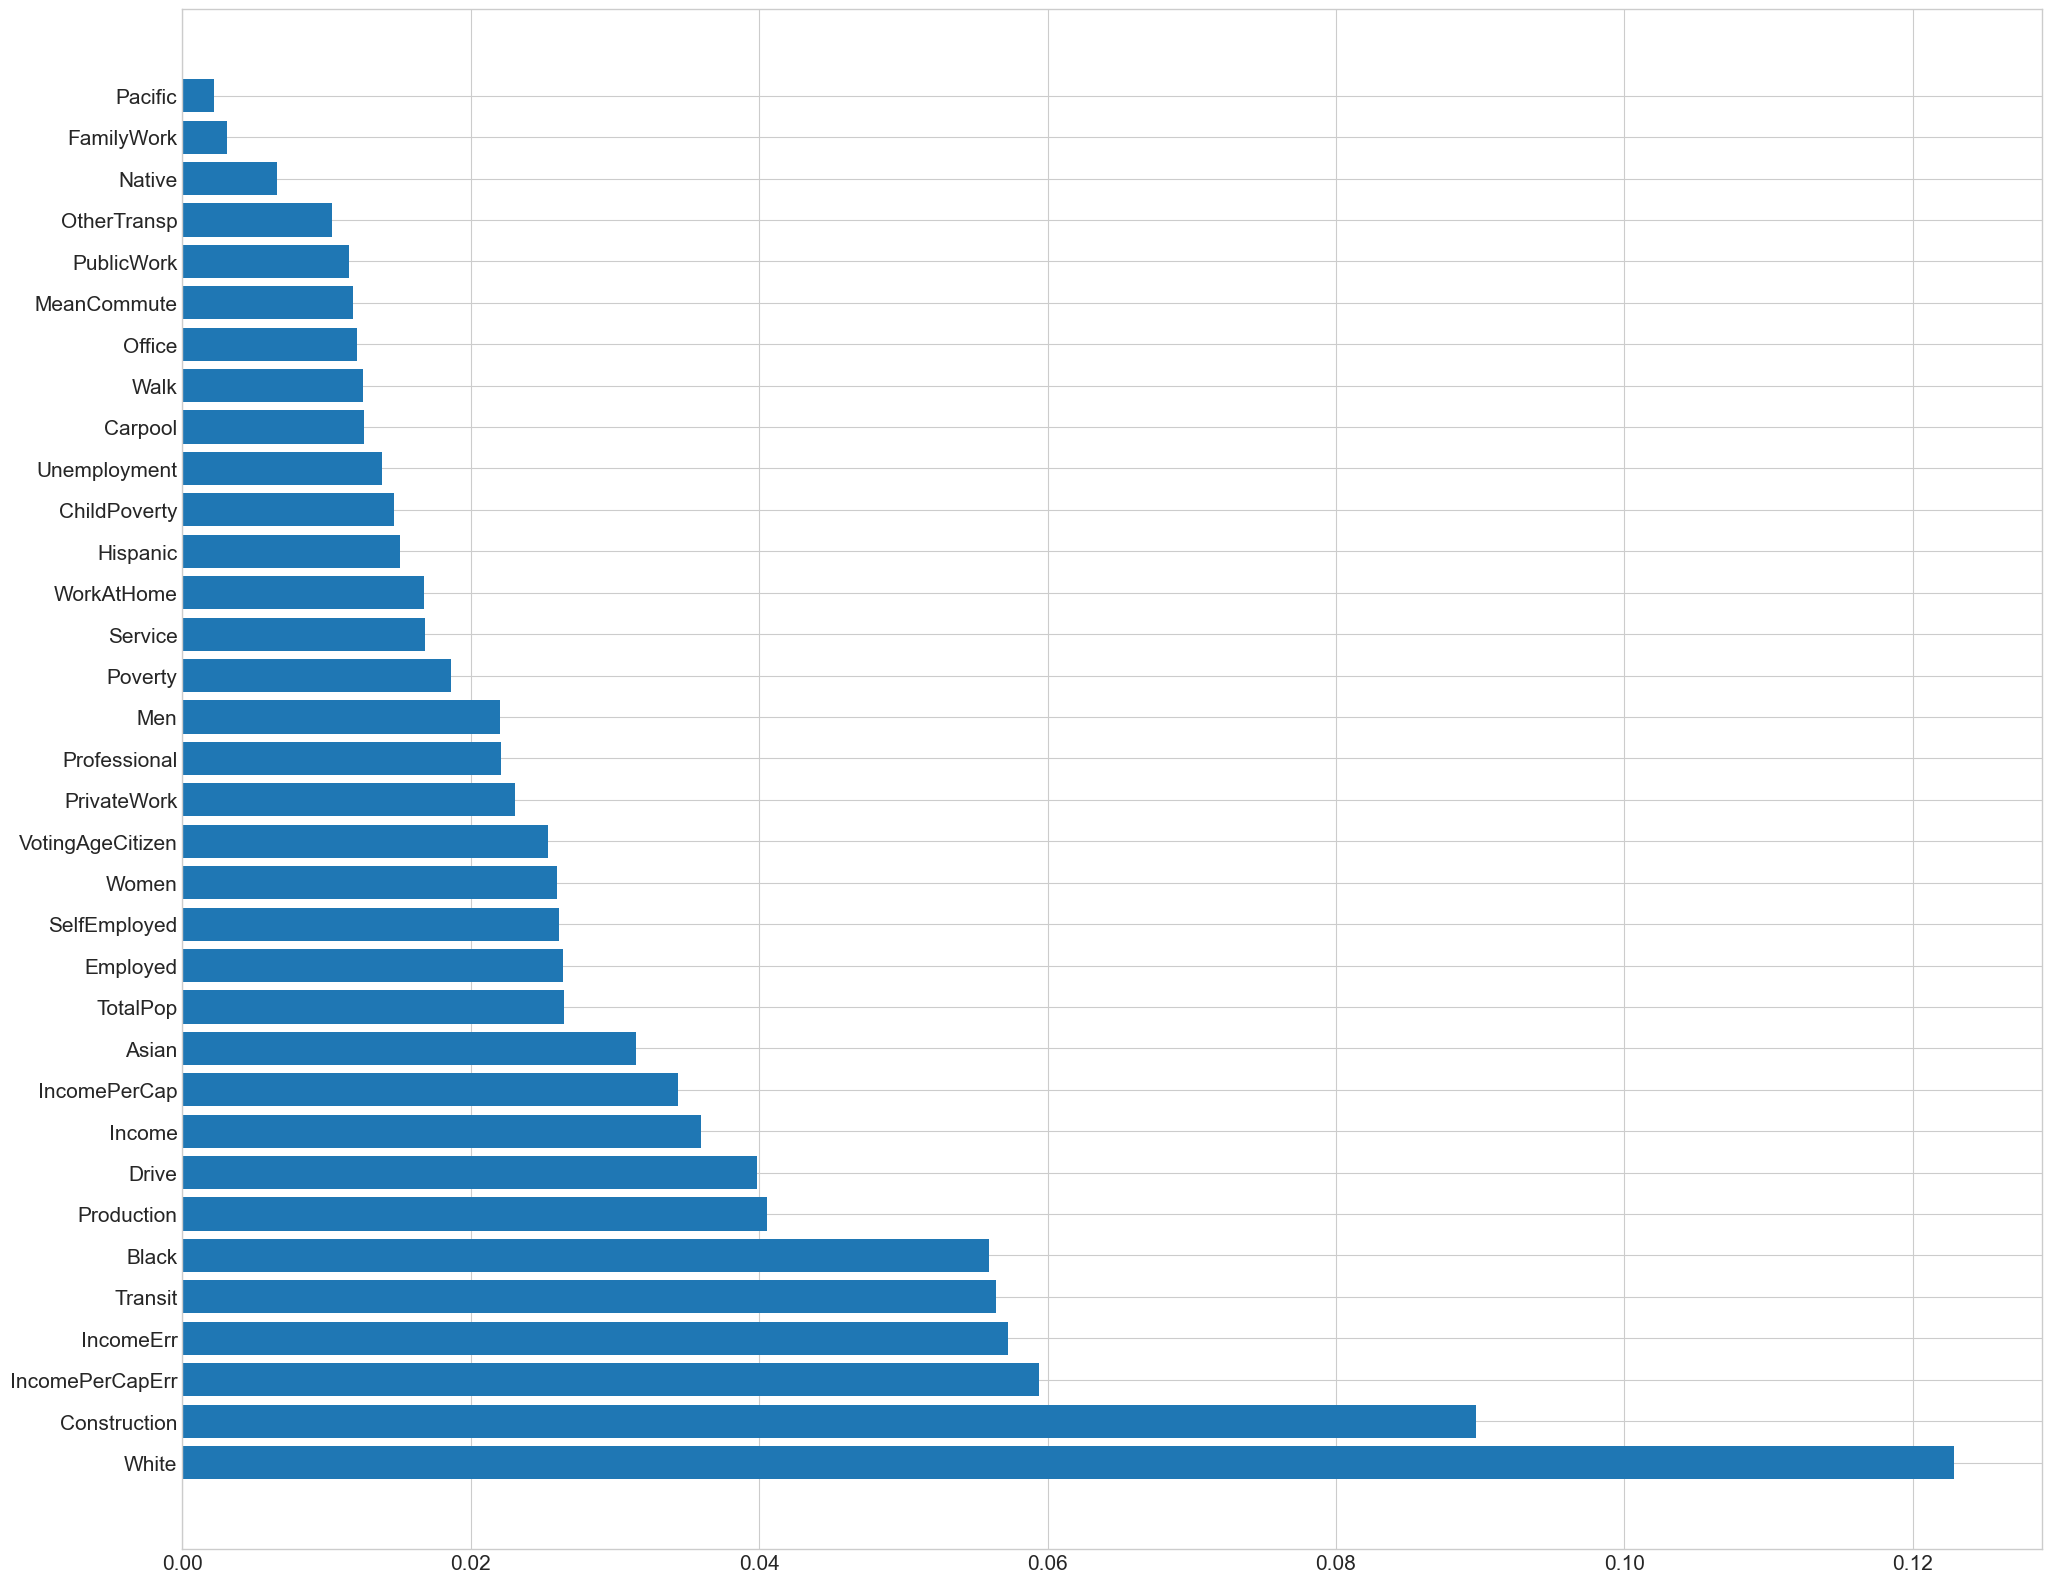

In [70]:
factor_to_weights = dict(zip(list(df_final_estimation.columns), random_forest.feature_importances_.tolist()))
factor_to_weights = dict(sorted(factor_to_weights.items(), key=lambda x: abs(x[1]), reverse=True))
plt.barh(list(factor_to_weights.keys()), list(map(lambda x: abs(x), factor_to_weights.values())))

In [71]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)
y_pred = decision_tree.predict(x_test)

In [72]:
print(metrics.classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.59      0.90      0.72       283
           1       0.95      0.73      0.82       644

    accuracy                           0.78       927
   macro avg       0.77      0.82      0.77       927
weighted avg       0.84      0.78      0.79       927



<BarContainer object of 34 artists>

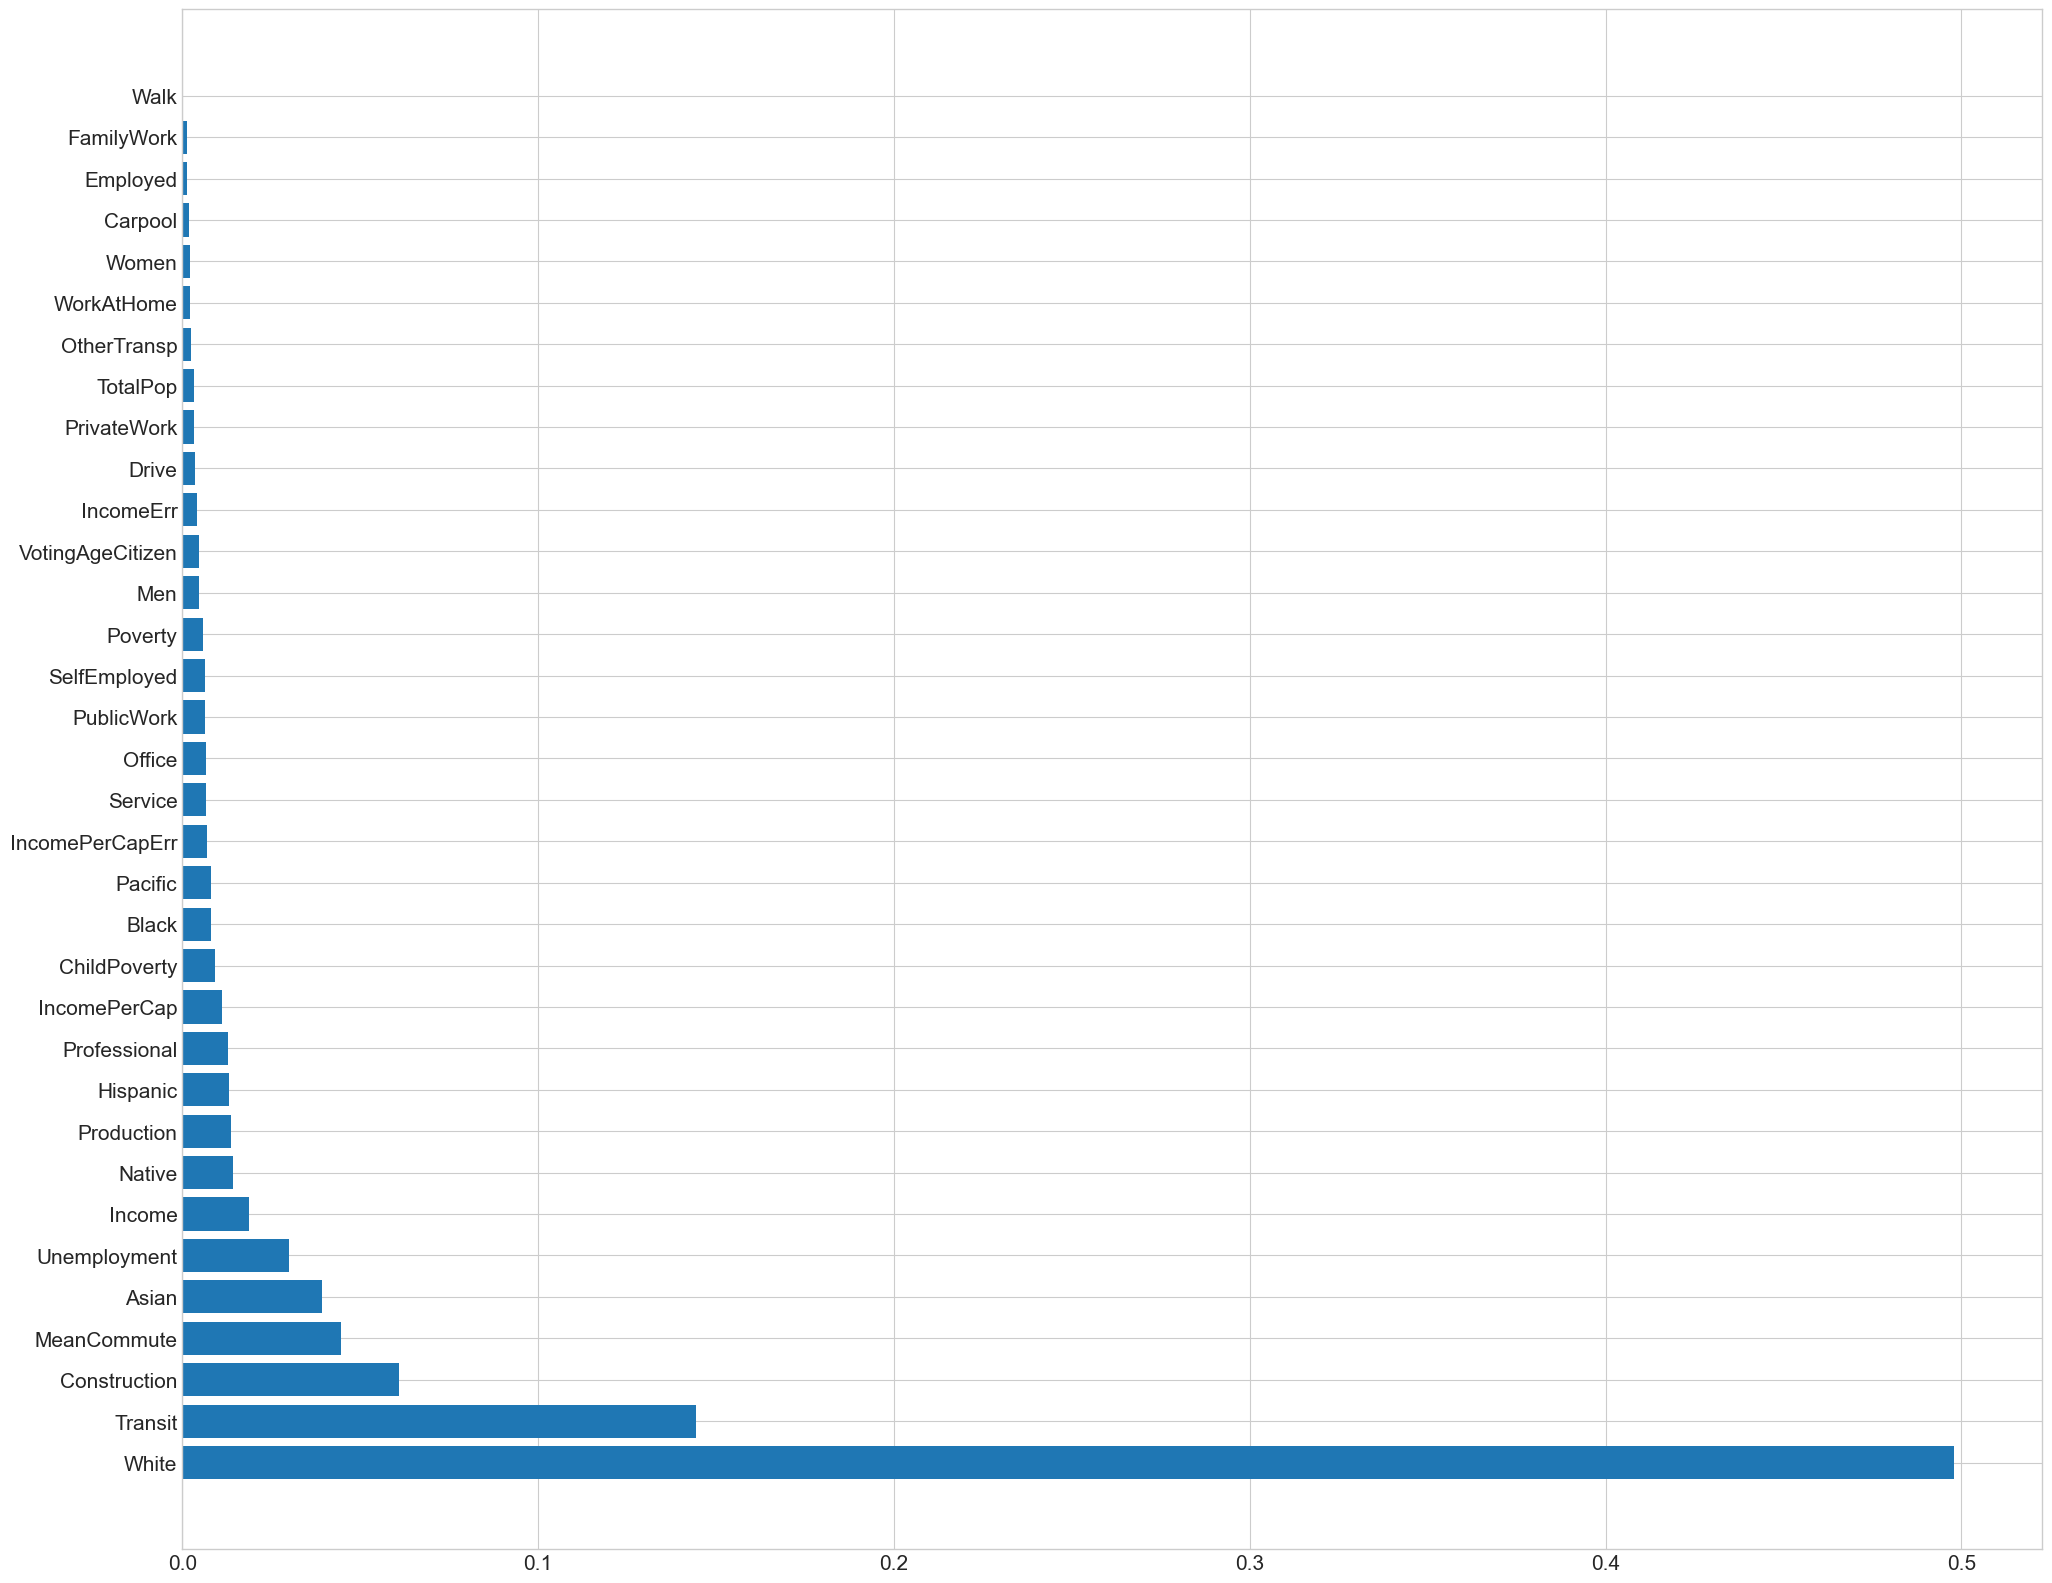

In [73]:
factor_to_weights = dict(zip(list(df_final_estimation.columns), decision_tree.feature_importances_.tolist()))
factor_to_weights = dict(sorted(factor_to_weights.items(), key=lambda x: abs(x[1]), reverse=True))
plt.barh(list(factor_to_weights.keys()), list(map(lambda x: abs(x), factor_to_weights.values())))

In [74]:
space={"max_depth": hp.quniform("max_depth", 3, 18, 1),
        "gamma": hp.uniform ("gamma", 1,9),
        "reg_alpha" : hp.quniform("reg_alpha", 40,180,1),
        "reg_lambda" : hp.uniform("reg_lambda", 0,1),
        "colsample_bytree" : hp.uniform("colsample_bytree", 0.5,1),
        "min_child_weight" : hp.quniform("min_child_weight", 0, 10, 1),
        "n_estimators": 180,
        "seed": 0
    }


def objective(space):
    clf=xgb.XGBClassifier(n_estimators =space["n_estimators"], max_depth = int(space["max_depth"]), gamma = space["gamma"],
                          reg_alpha = int(space["reg_alpha"]),min_child_weight=int(space["min_child_weight"]),
                          colsample_bytree=int(space["colsample_bytree"]), reg_lambda=int(space["reg_lambda"]))
    
    evaluation = [(x_train, y_train), (x_test, y_test)]
    
    clf.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    
    pred = clf.predict(x_test)
    accuracy = metrics.accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {"loss": -accuracy, "status": STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

SCORE:                                                 
0.7529665587918015                                     
SCORE:                                                                            
0.7659115426105717                                                                
SCORE:                                                                            
0.7756202804746494                                                                
SCORE:                                                                            
0.7540453074433657                                                                
SCORE:                                                                            
0.7540453074433657                                                                
SCORE:                                                                            
0.7540453074433657                                                                
SCORE:                                                    

In [75]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.8532732110171264, 'gamma': 1.3067832284942504, 'max_depth': 9.0, 'min_child_weight': 2.0, 'reg_alpha': 41.0, 'reg_lambda': 0.3137011093756191}


In [76]:
model_xgb_classifier = xgb.XGBClassifier(colsample_bytree=0.7977724768562602, gamma=1.6798954541033733,
                                         max_depth=7, reg_alpha=40, n_estimators=300, reg_lambda=0.3059373361966373)

model_xgb_classifier_fit = model_xgb_classifier.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)

In [77]:
print(metrics.classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.64      0.91      0.75       283
           1       0.95      0.77      0.85       644

    accuracy                           0.81       927
   macro avg       0.79      0.84      0.80       927
weighted avg       0.85      0.81      0.82       927



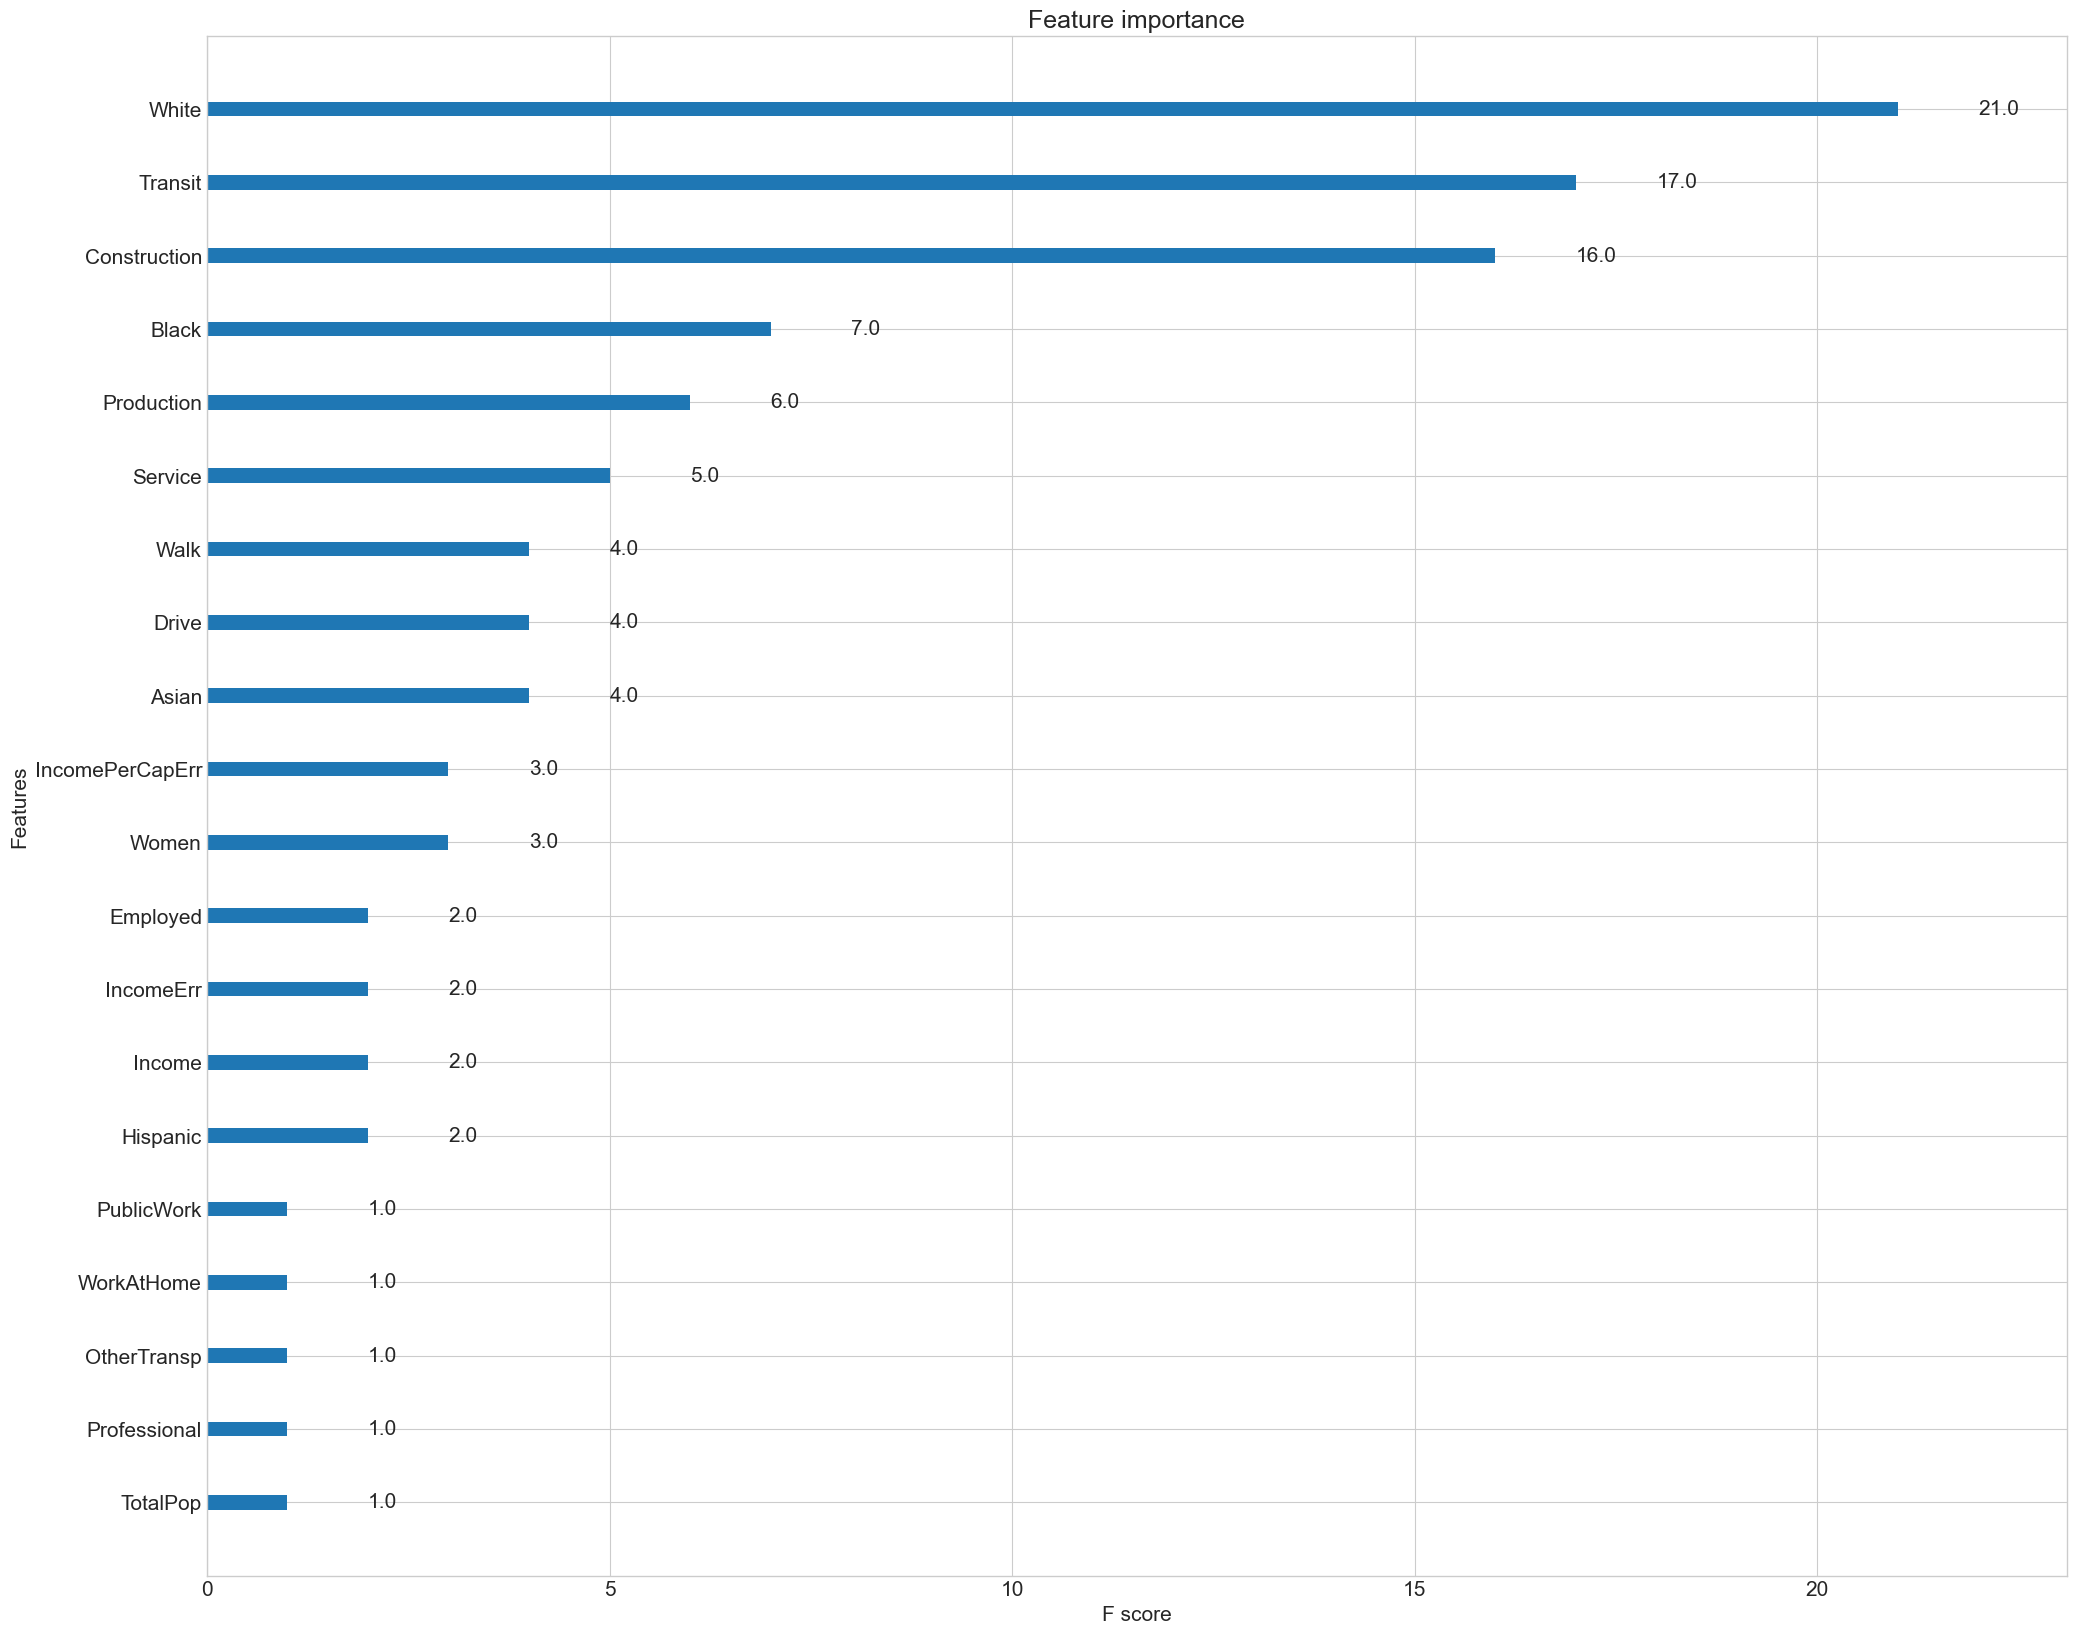

In [78]:
xgb.plot_importance(model_xgb_classifier_fit)
plt.rcParams['figure.figsize'] = [24, 20]
plt.show()